In [1]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split
import torch.utils.data
from torch.autograd import Variable
from tqdm import tqdm
import matplotlib.pyplot as plt
import joblib

In [11]:
from utils import plot_confusion_matrix
from dataset import read_dataset, prepare_dataset, normalise
from training import evaluate
from models import RNNModel, ComplexRNNModel
from constants import BASIC_TRAINING_COLS, FORCE_CLASS_COLS, MASS_CLASS_COLS

# Load passive dataset scaler

In [17]:
scaler = joblib.load("passive_force_scaler.sk")

# Load yoked dataset

In [18]:
yoked_trials = read_dataset("yoked_trials_exp1.h5")

In [19]:
X = []
Y = []

for trial in yoked_trials:
    X.append(np.array(trial[BASIC_TRAINING_COLS]).astype(np.float32))
    Y.append(np.argmax(np.array(trial[FORCE_CLASS_COLS].iloc[0])))

X = np.array(X)
Y = np.array(Y)

### Normalising yoked dataset

In [20]:
X_scaled = normalise(X, scaler, fit_scaler=False)

### Creating tensor dataset

In [21]:
X = torch.from_numpy(X_scaled)
Y = torch.from_numpy(Y).type(torch.LongTensor)
yoked_dataset = torch.utils.data.TensorDataset(X, Y)
yoked_loader = torch.utils.data.DataLoader(yoked_dataset, batch_size=32, shuffle=False)

# Load pre-trained model

In [22]:
model = ComplexRNNModel(16, 12, 6, 3)
# model.load_state_dict(torch.load("passive_force_model.pt"))
# model = RNNModel(16, 8, 1, 3)
model.load_state_dict(torch.load("passive_force_model.pt"))
model.eval()

ComplexRNNModel(
  (lstm): LSTM(16, 12, batch_first=True)
  (dropout): Dropout(p=0.25)
  (lstm_2): LSTM(12, 6, batch_first=True)
  (fc): Linear(in_features=6, out_features=3, bias=True)
)

In [23]:
accuracy, predicted = evaluate(model, yoked_loader, return_predicted=True)

In [24]:
print(accuracy)

38.70967741935484


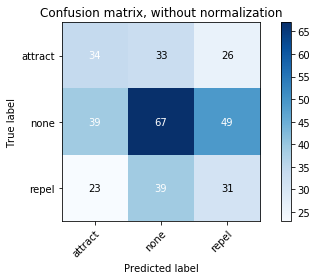

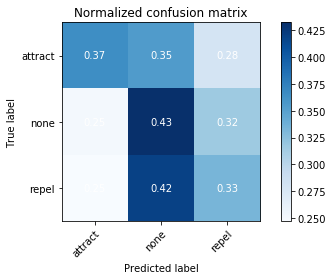

In [26]:
plot_confusion_matrix(Y, predicted, classes=FORCE_CLASS_COLS, normalize=False)
plot_confusion_matrix(Y, predicted, classes=FORCE_CLASS_COLS, normalize=True)

# Train models from scratch

In [23]:
from training import training_loop, evaluate

In [24]:
exp1_trials = read_dataset("yoked_trials_exp1.h5")
exp2_mass_trials = read_dataset("mass_trials_exp2.h5")
exp2_force_trials = read_dataset("force_trials_exp2.h5")

TRAINING_FOR = "force"

if TRAINING_FOR == "force":
    class_columns = FORCE_CLASS_COLS
    # yoked_trials = exp1_trials + exp2_force_trials
    yoked_trials = exp1_trials
else:
    class_columns = MASS_CLASS_COLS
    # yoked_trials = exp1_trials + exp2_mass_trials
    yoked_trials = exp1_trials

## Train force model

In [37]:
train_loader, val_loader = prepare_dataset(exp1_trials, FORCE_CLASS_COLS, normalise=True)

In [38]:
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

input_dim = 16   # input dimension
first_hidden_dim = 12  # hidden layer dimension
second_hidden_dim = 6     # number of hidden layers
output_dim = 3   # output dimension

model = ComplexRNNModel(input_dim, first_hidden_dim, second_hidden_dim, output_dim)
model = model.cuda()

error = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [39]:
model.train()

ComplexRNNModel(
  (lstm): LSTM(16, 12, batch_first=True)
  (lstm_2): LSTM(12, 6, batch_first=True)
  (fc): Linear(in_features=6, out_features=3, bias=True)
)

In [40]:
epoch_losses, epoch_accuracies = training_loop(model, optimizer, error, train_loader, val_loader, num_epochs=600)

  0%|          | 1/600 [00:00<04:24,  2.26it/s]

1.091107726097107 tensor(31, device='cuda:0')


  0%|          | 2/600 [00:00<04:16,  2.33it/s]

1.090125322341919 tensor(34, device='cuda:0')


  0%|          | 3/600 [00:01<04:12,  2.37it/s]

1.08915376663208 tensor(34, device='cuda:0')


  1%|          | 4/600 [00:01<04:09,  2.39it/s]

1.0881924629211426 tensor(37, device='cuda:0')


  1%|          | 5/600 [00:02<04:06,  2.42it/s]

1.0872411727905273 tensor(40, device='cuda:0')


  1%|          | 6/600 [00:02<04:04,  2.43it/s]

1.0862987041473389 tensor(42, device='cuda:0')


  1%|          | 7/600 [00:02<04:03,  2.43it/s]

1.0853642225265503 tensor(43, device='cuda:0')


  1%|▏         | 8/600 [00:03<04:03,  2.43it/s]

1.0844364166259766 tensor(43, device='cuda:0')


  2%|▏         | 9/600 [00:03<04:01,  2.45it/s]

1.0835137367248535 tensor(44, device='cuda:0')


  2%|▏         | 10/600 [00:04<04:00,  2.46it/s]

1.082594871520996 tensor(44, device='cuda:0')


  2%|▏         | 11/600 [00:04<03:57,  2.48it/s]

1.0816785097122192 tensor(44, device='cuda:0')


  2%|▏         | 12/600 [00:04<03:59,  2.46it/s]

1.0807639360427856 tensor(44, device='cuda:0')


  2%|▏         | 13/600 [00:05<03:56,  2.48it/s]

1.079850196838379 tensor(44, device='cuda:0')


  2%|▏         | 14/600 [00:05<03:56,  2.48it/s]

1.0789365768432617 tensor(44, device='cuda:0')


  2%|▎         | 15/600 [00:06<03:56,  2.47it/s]

1.0780225992202759 tensor(44, device='cuda:0')


  3%|▎         | 16/600 [00:06<03:55,  2.48it/s]

1.0771077871322632 tensor(44, device='cuda:0')


  3%|▎         | 17/600 [00:06<03:53,  2.50it/s]

1.0761913061141968 tensor(44, device='cuda:0')


  3%|▎         | 18/600 [00:07<03:52,  2.50it/s]

1.0752731561660767 tensor(44, device='cuda:0')


  3%|▎         | 19/600 [00:07<03:52,  2.50it/s]

1.0743526220321655 tensor(44, device='cuda:0')


  3%|▎         | 20/600 [00:08<03:52,  2.50it/s]

1.073428988456726 tensor(44, device='cuda:0')


  4%|▎         | 21/600 [00:08<03:52,  2.49it/s]

1.0725022554397583 tensor(44, device='cuda:0')


  4%|▎         | 22/600 [00:08<03:50,  2.50it/s]

1.071571946144104 tensor(44, device='cuda:0')


  4%|▍         | 23/600 [00:09<03:51,  2.50it/s]

1.0706373453140259 tensor(44, device='cuda:0')


  4%|▍         | 24/600 [00:09<03:51,  2.49it/s]

1.0696980953216553 tensor(44, device='cuda:0')


  4%|▍         | 25/600 [00:10<03:48,  2.51it/s]

1.0687533617019653 tensor(44, device='cuda:0')


  4%|▍         | 26/600 [00:10<03:50,  2.49it/s]

1.0678030252456665 tensor(44, device='cuda:0')


  4%|▍         | 27/600 [00:10<03:49,  2.49it/s]

1.0668466091156006 tensor(44, device='cuda:0')


  5%|▍         | 28/600 [00:11<03:50,  2.48it/s]

1.0658832788467407 tensor(44, device='cuda:0')


  5%|▍         | 29/600 [00:11<03:49,  2.49it/s]

1.0649123191833496 tensor(44, device='cuda:0')


  5%|▌         | 30/600 [00:12<03:48,  2.49it/s]

1.063933253288269 tensor(44, device='cuda:0')


  5%|▌         | 31/600 [00:12<03:51,  2.46it/s]

1.0629453659057617 tensor(44, device='cuda:0')


  5%|▌         | 32/600 [00:12<03:48,  2.48it/s]

1.0619480609893799 tensor(44, device='cuda:0')


  6%|▌         | 33/600 [00:13<03:45,  2.51it/s]

1.0609408617019653 tensor(44, device='cuda:0')


  6%|▌         | 34/600 [00:13<03:42,  2.54it/s]

1.0599229335784912 tensor(44, device='cuda:0')


  6%|▌         | 35/600 [00:14<03:45,  2.50it/s]

1.0588939189910889 tensor(44, device='cuda:0')


  6%|▌         | 36/600 [00:14<03:47,  2.48it/s]

1.0578529834747314 tensor(44, device='cuda:0')


  6%|▌         | 37/600 [00:14<03:56,  2.38it/s]

1.056800127029419 tensor(44, device='cuda:0')


  6%|▋         | 38/600 [00:15<03:51,  2.43it/s]

1.055734395980835 tensor(44, device='cuda:0')


  6%|▋         | 39/600 [00:15<03:38,  2.56it/s]

1.0546551942825317 tensor(44, device='cuda:0')


  7%|▋         | 40/600 [00:16<03:42,  2.52it/s]

1.0535622835159302 tensor(44, device='cuda:0')


  7%|▋         | 41/600 [00:16<03:40,  2.54it/s]

1.0524543523788452 tensor(44, device='cuda:0')


  7%|▋         | 42/600 [00:16<03:38,  2.55it/s]

1.0513306856155396 tensor(44, device='cuda:0')


  7%|▋         | 43/600 [00:17<03:39,  2.54it/s]

1.0501906871795654 tensor(44, device='cuda:0')


  7%|▋         | 44/600 [00:17<03:41,  2.51it/s]

1.0490326881408691 tensor(44, device='cuda:0')


  8%|▊         | 45/600 [00:18<03:39,  2.53it/s]

1.0478558540344238 tensor(44, device='cuda:0')


  8%|▊         | 46/600 [00:18<03:40,  2.51it/s]

1.0466586351394653 tensor(44, device='cuda:0')


  8%|▊         | 47/600 [00:18<03:43,  2.48it/s]

1.0454401969909668 tensor(44, device='cuda:0')


  8%|▊         | 48/600 [00:19<03:42,  2.49it/s]

1.0441986322402954 tensor(44, device='cuda:0')


  8%|▊         | 49/600 [00:19<03:40,  2.50it/s]

1.0429326295852661 tensor(44, device='cuda:0')


  8%|▊         | 50/600 [00:20<03:41,  2.48it/s]

1.0416406393051147 tensor(44, device='cuda:0')


  8%|▊         | 51/600 [00:20<03:38,  2.51it/s]

1.040320873260498 tensor(44, device='cuda:0')


  9%|▊         | 52/600 [00:20<03:40,  2.48it/s]

1.0389717817306519 tensor(44, device='cuda:0')


  9%|▉         | 53/600 [00:21<03:30,  2.60it/s]

1.0375914573669434 tensor(44, device='cuda:0')


  9%|▉         | 54/600 [00:21<03:30,  2.59it/s]

1.0361777544021606 tensor(44, device='cuda:0')


  9%|▉         | 55/600 [00:22<03:31,  2.58it/s]

1.0347294807434082 tensor(44, device='cuda:0')


  9%|▉         | 56/600 [00:22<03:32,  2.56it/s]

1.0332446098327637 tensor(43, device='cuda:0')


 10%|▉         | 57/600 [00:22<03:32,  2.56it/s]

1.0317209959030151 tensor(43, device='cuda:0')


 10%|▉         | 58/600 [00:23<03:24,  2.65it/s]

1.0301569700241089 tensor(43, device='cuda:0')


 10%|▉         | 59/600 [00:23<03:25,  2.63it/s]

1.0285511016845703 tensor(43, device='cuda:0')


 10%|█         | 60/600 [00:23<03:26,  2.62it/s]

1.0269020795822144 tensor(43, device='cuda:0')


 10%|█         | 61/600 [00:24<03:24,  2.63it/s]

1.0252084732055664 tensor(43, device='cuda:0')


 10%|█         | 62/600 [00:24<03:25,  2.62it/s]

1.0234687328338623 tensor(43, device='cuda:0')


 10%|█         | 63/600 [00:25<03:26,  2.60it/s]

1.0216811895370483 tensor(43, device='cuda:0')


 11%|█         | 64/600 [00:25<03:24,  2.62it/s]

1.0198442935943604 tensor(44, device='cuda:0')


 11%|█         | 65/600 [00:25<03:25,  2.60it/s]

1.017956256866455 tensor(44, device='cuda:0')


 11%|█         | 66/600 [00:26<03:22,  2.64it/s]

1.0160157680511475 tensor(43, device='cuda:0')


 11%|█         | 67/600 [00:26<03:22,  2.63it/s]

1.0140211582183838 tensor(43, device='cuda:0')


 11%|█▏        | 68/600 [00:27<03:23,  2.62it/s]

1.0119714736938477 tensor(43, device='cuda:0')


 12%|█▏        | 69/600 [00:27<03:21,  2.63it/s]

1.009865641593933 tensor(42, device='cuda:0')


 12%|█▏        | 70/600 [00:27<03:22,  2.61it/s]

1.0077025890350342 tensor(40, device='cuda:0')


 12%|█▏        | 71/600 [00:28<03:23,  2.60it/s]

1.0054813623428345 tensor(39, device='cuda:0')


 12%|█▏        | 72/600 [00:28<03:23,  2.60it/s]

1.0032017230987549 tensor(39, device='cuda:0')


 12%|█▏        | 73/600 [00:28<03:25,  2.57it/s]

1.0008618831634521 tensor(39, device='cuda:0')


 12%|█▏        | 74/600 [00:29<03:25,  2.57it/s]

0.9984601140022278 tensor(40, device='cuda:0')


 12%|█▎        | 75/600 [00:29<03:24,  2.56it/s]

0.9959954619407654 tensor(42, device='cuda:0')


 13%|█▎        | 76/600 [00:30<03:27,  2.53it/s]

0.993465781211853 tensor(42, device='cuda:0')


 13%|█▎        | 77/600 [00:30<03:19,  2.62it/s]

0.9908681511878967 tensor(42, device='cuda:0')


 13%|█▎        | 78/600 [00:30<03:20,  2.60it/s]

0.9881957769393921 tensor(42, device='cuda:0')


 13%|█▎        | 79/600 [00:31<03:23,  2.56it/s]

0.9854478240013123 tensor(42, device='cuda:0')


 13%|█▎        | 80/600 [00:31<03:22,  2.57it/s]

0.9826250672340393 tensor(42, device='cuda:0')


 14%|█▎        | 81/600 [00:32<03:21,  2.58it/s]

0.9797228574752808 tensor(42, device='cuda:0')


 14%|█▎        | 82/600 [00:32<03:22,  2.56it/s]

0.9767336845397949 tensor(43, device='cuda:0')


 14%|█▍        | 83/600 [00:32<03:19,  2.59it/s]

0.9736508727073669 tensor(43, device='cuda:0')


 14%|█▍        | 84/600 [00:33<03:18,  2.60it/s]

0.9704699516296387 tensor(43, device='cuda:0')


 14%|█▍        | 85/600 [00:33<03:18,  2.60it/s]

0.9685766696929932 tensor(43, device='cuda:0')


 14%|█▍        | 86/600 [00:33<03:20,  2.57it/s]

0.9638186097145081 tensor(43, device='cuda:0')


 14%|█▍        | 87/600 [00:34<03:19,  2.57it/s]

0.9603610038757324 tensor(43, device='cuda:0')


 15%|█▍        | 88/600 [00:34<03:18,  2.58it/s]

0.9568106532096863 tensor(43, device='cuda:0')


 15%|█▍        | 89/600 [00:35<03:17,  2.59it/s]

0.953161895275116 tensor(43, device='cuda:0')


 15%|█▌        | 90/600 [00:35<03:16,  2.59it/s]

0.9494098424911499 tensor(42, device='cuda:0')


 15%|█▌        | 91/600 [00:35<03:17,  2.58it/s]

0.9455576539039612 tensor(42, device='cuda:0')


 15%|█▌        | 92/600 [00:36<03:15,  2.60it/s]

0.9416124820709229 tensor(42, device='cuda:0')


 16%|█▌        | 93/600 [00:36<03:14,  2.60it/s]

0.9375817775726318 tensor(42, device='cuda:0')


 16%|█▌        | 94/600 [00:37<03:15,  2.59it/s]

0.9334725737571716 tensor(42, device='cuda:0')


 16%|█▌        | 95/600 [00:37<03:15,  2.59it/s]

0.9292932748794556 tensor(42, device='cuda:0')


 16%|█▌        | 96/600 [00:37<03:14,  2.59it/s]

0.9250500798225403 tensor(40, device='cuda:0')


 16%|█▌        | 97/600 [00:38<03:17,  2.55it/s]

0.9207411408424377 tensor(40, device='cuda:0')


 16%|█▋        | 98/600 [00:38<03:18,  2.52it/s]

0.9163579344749451 tensor(40, device='cuda:0')


 16%|█▋        | 99/600 [00:39<03:18,  2.53it/s]

0.9118881225585938 tensor(39, device='cuda:0')


 17%|█▋        | 100/600 [00:39<03:19,  2.51it/s]

0.9073139429092407 tensor(39, device='cuda:0')


 17%|█▋        | 101/600 [00:39<03:20,  2.49it/s]

0.9026047587394714 tensor(39, device='cuda:0')


 17%|█▋        | 102/600 [00:40<03:17,  2.52it/s]

0.8977311253547668 tensor(39, device='cuda:0')


 17%|█▋        | 103/600 [00:40<03:17,  2.51it/s]

0.8927120566368103 tensor(40, device='cuda:0')


 17%|█▋        | 104/600 [00:41<03:18,  2.49it/s]

0.8875957727432251 tensor(40, device='cuda:0')


 18%|█▊        | 105/600 [00:41<03:16,  2.52it/s]

0.882398784160614 tensor(37, device='cuda:0')


 18%|█▊        | 106/600 [00:41<03:14,  2.53it/s]

0.8771288990974426 tensor(37, device='cuda:0')


 18%|█▊        | 107/600 [00:42<03:13,  2.54it/s]

0.8717649579048157 tensor(37, device='cuda:0')


 18%|█▊        | 108/600 [00:42<03:11,  2.57it/s]

0.8662909269332886 tensor(37, device='cuda:0')


 18%|█▊        | 109/600 [00:42<03:09,  2.59it/s]

0.8607034683227539 tensor(37, device='cuda:0')


 18%|█▊        | 110/600 [00:43<03:11,  2.56it/s]

0.8602491617202759 tensor(39, device='cuda:0')


 18%|█▊        | 111/600 [00:43<03:12,  2.55it/s]

0.8496317863464355 tensor(39, device='cuda:0')


 19%|█▊        | 112/600 [00:44<03:12,  2.54it/s]

0.8441210985183716 tensor(39, device='cuda:0')


 19%|█▉        | 113/600 [00:44<03:09,  2.57it/s]

0.8384448289871216 tensor(40, device='cuda:0')


 19%|█▉        | 114/600 [00:44<03:09,  2.57it/s]

0.8324997425079346 tensor(40, device='cuda:0')


 19%|█▉        | 115/600 [00:45<03:08,  2.57it/s]

0.8265045881271362 tensor(40, device='cuda:0')


 19%|█▉        | 116/600 [00:45<03:01,  2.67it/s]

0.8203635215759277 tensor(43, device='cuda:0')


 20%|█▉        | 117/600 [00:46<03:03,  2.64it/s]

0.8140261173248291 tensor(42, device='cuda:0')


 20%|█▉        | 118/600 [00:46<03:05,  2.60it/s]

0.8075773119926453 tensor(42, device='cuda:0')


 20%|█▉        | 119/600 [00:46<03:05,  2.59it/s]

0.8012000322341919 tensor(42, device='cuda:0')


 20%|██        | 120/600 [00:47<03:07,  2.56it/s]

0.7950395941734314 tensor(40, device='cuda:0')


 20%|██        | 121/600 [00:47<03:07,  2.55it/s]

0.7890949845314026 tensor(40, device='cuda:0')


 20%|██        | 122/600 [00:48<03:06,  2.56it/s]

0.7831545472145081 tensor(40, device='cuda:0')


 20%|██        | 123/600 [00:48<03:07,  2.54it/s]

0.7769322991371155 tensor(39, device='cuda:0')


 21%|██        | 124/600 [00:48<03:08,  2.53it/s]

0.770804226398468 tensor(39, device='cuda:0')


 21%|██        | 125/600 [00:49<03:07,  2.53it/s]

0.7647863626480103 tensor(39, device='cuda:0')


 21%|██        | 126/600 [00:49<03:06,  2.54it/s]

0.7587440013885498 tensor(39, device='cuda:0')


 21%|██        | 127/600 [00:50<03:07,  2.52it/s]

0.7528074383735657 tensor(36, device='cuda:0')


 21%|██▏       | 128/600 [00:50<03:08,  2.50it/s]

0.7467250823974609 tensor(36, device='cuda:0')


 22%|██▏       | 129/600 [00:50<03:10,  2.48it/s]

0.7405322194099426 tensor(34, device='cuda:0')


 22%|██▏       | 130/600 [00:51<03:11,  2.45it/s]

0.741889238357544 tensor(34, device='cuda:0')


 22%|██▏       | 131/600 [00:51<03:12,  2.43it/s]

0.7362866401672363 tensor(34, device='cuda:0')


 22%|██▏       | 132/600 [00:52<03:13,  2.42it/s]

0.7304612398147583 tensor(34, device='cuda:0')


 22%|██▏       | 133/600 [00:52<03:13,  2.42it/s]

0.7289950251579285 tensor(33, device='cuda:0')


 22%|██▏       | 134/600 [00:52<03:12,  2.42it/s]

0.7231351733207703 tensor(33, device='cuda:0')


 22%|██▎       | 135/600 [00:53<03:12,  2.42it/s]

0.7137808799743652 tensor(33, device='cuda:0')


 23%|██▎       | 136/600 [00:53<03:13,  2.40it/s]

0.7076897621154785 tensor(33, device='cuda:0')


 23%|██▎       | 137/600 [00:54<03:12,  2.40it/s]

0.7008606195449829 tensor(33, device='cuda:0')


 23%|██▎       | 138/600 [00:54<03:11,  2.41it/s]

0.6942019462585449 tensor(33, device='cuda:0')


 23%|██▎       | 139/600 [00:55<03:11,  2.41it/s]

0.6885666847229004 tensor(31, device='cuda:0')


 23%|██▎       | 140/600 [00:55<03:10,  2.41it/s]

0.6837174296379089 tensor(30, device='cuda:0')


 24%|██▎       | 141/600 [00:55<03:11,  2.40it/s]

0.6792198419570923 tensor(30, device='cuda:0')


 24%|██▎       | 142/600 [00:56<03:12,  2.38it/s]

0.6749930381774902 tensor(31, device='cuda:0')


 24%|██▍       | 143/600 [00:56<03:10,  2.40it/s]

0.6720844507217407 tensor(33, device='cuda:0')


 24%|██▍       | 144/600 [00:57<03:08,  2.41it/s]

0.6712145805358887 tensor(33, device='cuda:0')


 24%|██▍       | 145/600 [00:57<03:08,  2.42it/s]

0.6657600998878479 tensor(31, device='cuda:0')


 24%|██▍       | 146/600 [00:57<03:07,  2.42it/s]

0.663960874080658 tensor(31, device='cuda:0')


 24%|██▍       | 147/600 [00:58<03:08,  2.41it/s]

0.6580742001533508 tensor(31, device='cuda:0')


 25%|██▍       | 148/600 [00:58<03:07,  2.41it/s]

0.6543859839439392 tensor(30, device='cuda:0')


 25%|██▍       | 149/600 [00:59<03:07,  2.40it/s]

0.6425336599349976 tensor(30, device='cuda:0')


 25%|██▌       | 150/600 [00:59<03:08,  2.39it/s]

0.6387683153152466 tensor(30, device='cuda:0')


 25%|██▌       | 151/600 [01:00<03:07,  2.40it/s]

0.6346035003662109 tensor(30, device='cuda:0')


 25%|██▌       | 152/600 [01:00<03:06,  2.40it/s]

0.6300826072692871 tensor(30, device='cuda:0')


 26%|██▌       | 153/600 [01:00<03:05,  2.41it/s]

0.6261427998542786 tensor(30, device='cuda:0')


 26%|██▌       | 154/600 [01:01<03:05,  2.40it/s]

0.6217216849327087 tensor(30, device='cuda:0')


 26%|██▌       | 155/600 [01:01<03:05,  2.40it/s]

0.6173394322395325 tensor(30, device='cuda:0')


 26%|██▌       | 156/600 [01:02<03:05,  2.40it/s]

0.6126804947853088 tensor(30, device='cuda:0')


 26%|██▌       | 157/600 [01:02<03:05,  2.39it/s]

0.6086554527282715 tensor(30, device='cuda:0')


 26%|██▋       | 158/600 [01:02<03:03,  2.41it/s]

0.6133995056152344 tensor(30, device='cuda:0')


 26%|██▋       | 159/600 [01:03<03:01,  2.42it/s]

0.6066024303436279 tensor(30, device='cuda:0')


 27%|██▋       | 160/600 [01:03<03:00,  2.44it/s]

0.6017111539840698 tensor(30, device='cuda:0')


 27%|██▋       | 161/600 [01:04<02:57,  2.47it/s]

0.597644567489624 tensor(30, device='cuda:0')


 27%|██▋       | 162/600 [01:04<02:56,  2.48it/s]

0.6003251075744629 tensor(30, device='cuda:0')


 27%|██▋       | 163/600 [01:04<02:49,  2.58it/s]

0.5962263941764832 tensor(28, device='cuda:0')


 27%|██▋       | 164/600 [01:05<02:48,  2.58it/s]

0.598365843296051 tensor(28, device='cuda:0')


 28%|██▊       | 165/600 [01:05<02:49,  2.57it/s]

0.5988306403160095 tensor(28, device='cuda:0')


 28%|██▊       | 166/600 [01:06<02:50,  2.54it/s]

0.6062695980072021 tensor(30, device='cuda:0')


 28%|██▊       | 167/600 [01:06<02:50,  2.53it/s]

0.6067029237747192 tensor(30, device='cuda:0')


 28%|██▊       | 168/600 [01:06<02:51,  2.52it/s]

0.6064595580101013 tensor(30, device='cuda:0')


 28%|██▊       | 169/600 [01:07<02:52,  2.50it/s]

0.6052823066711426 tensor(30, device='cuda:0')


 28%|██▊       | 170/600 [01:07<02:52,  2.49it/s]

0.5977959632873535 tensor(30, device='cuda:0')


 28%|██▊       | 171/600 [01:08<02:52,  2.49it/s]

0.5951333045959473 tensor(30, device='cuda:0')


 29%|██▊       | 172/600 [01:08<02:51,  2.50it/s]

0.5914821624755859 tensor(31, device='cuda:0')


 29%|██▉       | 173/600 [01:08<02:49,  2.52it/s]

0.5847414135932922 tensor(31, device='cuda:0')


 29%|██▉       | 174/600 [01:09<02:42,  2.63it/s]

0.5820868015289307 tensor(33, device='cuda:0')


 29%|██▉       | 175/600 [01:09<02:42,  2.61it/s]

0.5798568725585938 tensor(33, device='cuda:0')


 29%|██▉       | 176/600 [01:09<02:43,  2.60it/s]

0.5771164894104004 tensor(33, device='cuda:0')


 30%|██▉       | 177/600 [01:10<02:42,  2.60it/s]

0.5711870193481445 tensor(34, device='cuda:0')


 30%|██▉       | 178/600 [01:10<02:42,  2.59it/s]

0.5689777135848999 tensor(33, device='cuda:0')


 30%|██▉       | 179/600 [01:11<02:42,  2.58it/s]

0.5670909285545349 tensor(33, device='cuda:0')


 30%|███       | 180/600 [01:11<02:36,  2.68it/s]

0.5655094385147095 tensor(33, device='cuda:0')


 30%|███       | 181/600 [01:11<02:38,  2.65it/s]

0.5642163157463074 tensor(34, device='cuda:0')


 30%|███       | 182/600 [01:12<02:39,  2.62it/s]

0.5625590682029724 tensor(34, device='cuda:0')


 30%|███       | 183/600 [01:12<02:39,  2.62it/s]

0.5595619082450867 tensor(34, device='cuda:0')


 31%|███       | 184/600 [01:13<02:39,  2.61it/s]

0.5577481985092163 tensor(34, device='cuda:0')


 31%|███       | 185/600 [01:13<02:38,  2.62it/s]

0.5561808347702026 tensor(34, device='cuda:0')


 31%|███       | 186/600 [01:13<02:32,  2.71it/s]

0.5546671152114868 tensor(34, device='cuda:0')


 31%|███       | 187/600 [01:14<02:33,  2.69it/s]

0.5530160665512085 tensor(36, device='cuda:0')


 31%|███▏      | 188/600 [01:14<02:34,  2.67it/s]

0.5513942837715149 tensor(36, device='cuda:0')


 32%|███▏      | 189/600 [01:14<02:35,  2.64it/s]

0.5498569011688232 tensor(34, device='cuda:0')


 32%|███▏      | 190/600 [01:15<02:30,  2.72it/s]

0.5482566356658936 tensor(34, device='cuda:0')


 32%|███▏      | 191/600 [01:15<02:33,  2.67it/s]

0.5465824604034424 tensor(34, device='cuda:0')


 32%|███▏      | 192/600 [01:16<02:34,  2.64it/s]

0.5450525879859924 tensor(34, device='cuda:0')


 32%|███▏      | 193/600 [01:16<02:34,  2.64it/s]

0.5435628294944763 tensor(34, device='cuda:0')


 32%|███▏      | 194/600 [01:16<02:34,  2.63it/s]

0.5512709617614746 tensor(34, device='cuda:0')


 32%|███▎      | 195/600 [01:17<02:34,  2.62it/s]

0.5427938103675842 tensor(36, device='cuda:0')


 33%|███▎      | 196/600 [01:17<02:33,  2.63it/s]

0.5418829917907715 tensor(36, device='cuda:0')


 33%|███▎      | 197/600 [01:17<02:33,  2.63it/s]

0.5403745174407959 tensor(36, device='cuda:0')


 33%|███▎      | 198/600 [01:18<02:34,  2.60it/s]

0.5388811230659485 tensor(36, device='cuda:0')


 33%|███▎      | 199/600 [01:18<02:37,  2.55it/s]

0.5441745519638062 tensor(36, device='cuda:0')


 33%|███▎      | 200/600 [01:19<02:38,  2.53it/s]

0.5427840352058411 tensor(36, device='cuda:0')


 34%|███▎      | 201/600 [01:19<02:38,  2.51it/s]

0.5414116382598877 tensor(36, device='cuda:0')


 34%|███▎      | 202/600 [01:19<02:36,  2.54it/s]

0.5389339327812195 tensor(36, device='cuda:0')


 34%|███▍      | 203/600 [01:20<02:35,  2.56it/s]

0.537764310836792 tensor(36, device='cuda:0')


 34%|███▍      | 204/600 [01:20<02:34,  2.57it/s]

0.5386103987693787 tensor(36, device='cuda:0')


 34%|███▍      | 205/600 [01:21<02:33,  2.57it/s]

0.5285747051239014 tensor(36, device='cuda:0')


 34%|███▍      | 206/600 [01:21<02:33,  2.57it/s]

0.527472972869873 tensor(36, device='cuda:0')


 34%|███▍      | 207/600 [01:21<02:33,  2.56it/s]

0.5263141393661499 tensor(36, device='cuda:0')


 35%|███▍      | 208/600 [01:22<02:34,  2.54it/s]

0.5276452898979187 tensor(36, device='cuda:0')


 35%|███▍      | 209/600 [01:22<02:33,  2.54it/s]

0.5264715552330017 tensor(36, device='cuda:0')


 35%|███▌      | 210/600 [01:23<02:33,  2.54it/s]

0.5252638459205627 tensor(37, device='cuda:0')


 35%|███▌      | 211/600 [01:23<02:32,  2.55it/s]

0.5240209102630615 tensor(37, device='cuda:0')


 35%|███▌      | 212/600 [01:23<02:33,  2.53it/s]

0.5202266573905945 tensor(37, device='cuda:0')


 36%|███▌      | 213/600 [01:24<02:31,  2.56it/s]

0.5189180374145508 tensor(37, device='cuda:0')


 36%|███▌      | 214/600 [01:24<02:31,  2.56it/s]

0.5247504115104675 tensor(39, device='cuda:0')


 36%|███▌      | 215/600 [01:25<02:31,  2.54it/s]

0.5233559012413025 tensor(36, device='cuda:0')


 36%|███▌      | 216/600 [01:25<02:30,  2.54it/s]

0.5178734660148621 tensor(36, device='cuda:0')


 36%|███▌      | 217/600 [01:25<02:30,  2.54it/s]

0.5171330571174622 tensor(36, device='cuda:0')


 36%|███▋      | 218/600 [01:26<02:30,  2.54it/s]

0.5158029198646545 tensor(36, device='cuda:0')


 36%|███▋      | 219/600 [01:26<02:29,  2.54it/s]

0.5142238736152649 tensor(36, device='cuda:0')


 37%|███▋      | 220/600 [01:26<02:28,  2.56it/s]

0.5082983374595642 tensor(36, device='cuda:0')


 37%|███▋      | 221/600 [01:27<02:28,  2.55it/s]

0.5066806674003601 tensor(36, device='cuda:0')


 37%|███▋      | 222/600 [01:27<02:27,  2.57it/s]

0.5015222430229187 tensor(34, device='cuda:0')


 37%|███▋      | 223/600 [01:28<02:26,  2.57it/s]

0.5075721740722656 tensor(34, device='cuda:0')


 37%|███▋      | 224/600 [01:28<02:26,  2.57it/s]

0.506132185459137 tensor(34, device='cuda:0')


 38%|███▊      | 225/600 [01:28<02:25,  2.57it/s]

0.5045847296714783 tensor(31, device='cuda:0')


 38%|███▊      | 226/600 [01:29<02:25,  2.57it/s]

0.4955838620662689 tensor(31, device='cuda:0')


 38%|███▊      | 227/600 [01:29<02:25,  2.57it/s]

0.49796122312545776 tensor(31, device='cuda:0')


 38%|███▊      | 228/600 [01:30<02:24,  2.57it/s]

0.4930494427680969 tensor(33, device='cuda:0')


 38%|███▊      | 229/600 [01:30<02:24,  2.57it/s]

0.4935297667980194 tensor(33, device='cuda:0')


 38%|███▊      | 230/600 [01:30<02:23,  2.58it/s]

0.49106764793395996 tensor(33, device='cuda:0')


 38%|███▊      | 231/600 [01:31<02:21,  2.61it/s]

0.4888761043548584 tensor(33, device='cuda:0')


 39%|███▊      | 232/600 [01:31<02:21,  2.60it/s]

0.4870283603668213 tensor(33, device='cuda:0')


 39%|███▉      | 233/600 [01:32<02:21,  2.59it/s]

0.48542386293411255 tensor(33, device='cuda:0')


 39%|███▉      | 234/600 [01:32<02:23,  2.56it/s]

0.4839828610420227 tensor(33, device='cuda:0')


 39%|███▉      | 235/600 [01:32<02:22,  2.56it/s]

0.48262226581573486 tensor(33, device='cuda:0')


 39%|███▉      | 236/600 [01:33<02:22,  2.56it/s]

0.48125356435775757 tensor(33, device='cuda:0')


 40%|███▉      | 237/600 [01:33<02:21,  2.56it/s]

0.47974395751953125 tensor(33, device='cuda:0')


 40%|███▉      | 238/600 [01:33<02:21,  2.56it/s]

0.47834840416908264 tensor(34, device='cuda:0')


 40%|███▉      | 239/600 [01:34<02:20,  2.57it/s]

0.4742904007434845 tensor(34, device='cuda:0')


 40%|████      | 240/600 [01:34<02:22,  2.52it/s]

0.4730049669742584 tensor(34, device='cuda:0')


 40%|████      | 241/600 [01:35<02:21,  2.53it/s]

0.4717516601085663 tensor(34, device='cuda:0')


 40%|████      | 242/600 [01:35<02:22,  2.51it/s]

0.47053244709968567 tensor(36, device='cuda:0')


 40%|████      | 243/600 [01:35<02:21,  2.52it/s]

0.46932926774024963 tensor(36, device='cuda:0')


 41%|████      | 244/600 [01:36<02:20,  2.54it/s]

0.4681280851364136 tensor(36, device='cuda:0')


 41%|████      | 245/600 [01:36<02:19,  2.54it/s]

0.4669233560562134 tensor(36, device='cuda:0')


 41%|████      | 246/600 [01:37<02:18,  2.55it/s]

0.476853609085083 tensor(36, device='cuda:0')


 41%|████      | 247/600 [01:37<02:20,  2.51it/s]

0.4727979600429535 tensor(36, device='cuda:0')


 41%|████▏     | 248/600 [01:37<02:19,  2.53it/s]

0.4636857211589813 tensor(36, device='cuda:0')


 42%|████▏     | 249/600 [01:38<02:17,  2.56it/s]

0.46273139119148254 tensor(36, device='cuda:0')


 42%|████▏     | 250/600 [01:38<02:16,  2.57it/s]

0.46464186906814575 tensor(34, device='cuda:0')


 42%|████▏     | 251/600 [01:39<02:15,  2.57it/s]

0.46987250447273254 tensor(34, device='cuda:0')


 42%|████▏     | 252/600 [01:39<02:15,  2.56it/s]

0.4627232551574707 tensor(34, device='cuda:0')


 42%|████▏     | 253/600 [01:39<02:14,  2.58it/s]

0.4616645276546478 tensor(34, device='cuda:0')


 42%|████▏     | 254/600 [01:40<02:09,  2.67it/s]

0.4605950713157654 tensor(34, device='cuda:0')


 42%|████▎     | 255/600 [01:40<02:10,  2.64it/s]

0.45956817269325256 tensor(34, device='cuda:0')


 43%|████▎     | 256/600 [01:40<02:11,  2.63it/s]

0.4557006359100342 tensor(34, device='cuda:0')


 43%|████▎     | 257/600 [01:41<02:06,  2.71it/s]

0.4546474814414978 tensor(34, device='cuda:0')


 43%|████▎     | 258/600 [01:41<02:08,  2.67it/s]

0.4621664881706238 tensor(34, device='cuda:0')


 43%|████▎     | 259/600 [01:42<02:09,  2.64it/s]

0.46123337745666504 tensor(34, device='cuda:0')


 43%|████▎     | 260/600 [01:42<02:09,  2.62it/s]

0.4517284035682678 tensor(34, device='cuda:0')


 44%|████▎     | 261/600 [01:42<02:09,  2.61it/s]

0.4507550895214081 tensor(34, device='cuda:0')


 44%|████▎     | 262/600 [01:43<02:10,  2.60it/s]

0.44977226853370667 tensor(34, device='cuda:0')


 44%|████▍     | 263/600 [01:43<02:05,  2.69it/s]

0.45270657539367676 tensor(34, device='cuda:0')


 44%|████▍     | 264/600 [01:43<02:03,  2.73it/s]

0.4479936361312866 tensor(34, device='cuda:0')


 44%|████▍     | 265/600 [01:44<02:05,  2.68it/s]

0.44727733731269836 tensor(34, device='cuda:0')


 44%|████▍     | 266/600 [01:44<02:05,  2.66it/s]

0.4464622139930725 tensor(33, device='cuda:0')


 44%|████▍     | 267/600 [01:45<02:06,  2.64it/s]

0.44857025146484375 tensor(33, device='cuda:0')


 45%|████▍     | 268/600 [01:45<02:06,  2.62it/s]

0.4476920962333679 tensor(33, device='cuda:0')


 45%|████▍     | 269/600 [01:45<02:06,  2.61it/s]

0.44683533906936646 tensor(33, device='cuda:0')


 45%|████▌     | 270/600 [01:46<02:06,  2.60it/s]

0.44316697120666504 tensor(33, device='cuda:0')


 45%|████▌     | 271/600 [01:46<02:02,  2.69it/s]

0.44230276346206665 tensor(33, device='cuda:0')


 45%|████▌     | 272/600 [01:47<02:03,  2.65it/s]

0.4414396584033966 tensor(34, device='cuda:0')


 46%|████▌     | 273/600 [01:47<02:04,  2.62it/s]

0.44053953886032104 tensor(34, device='cuda:0')


 46%|████▌     | 274/600 [01:47<02:04,  2.62it/s]

0.4468322992324829 tensor(36, device='cuda:0')


 46%|████▌     | 275/600 [01:48<02:04,  2.61it/s]

0.43907928466796875 tensor(36, device='cuda:0')


 46%|████▌     | 276/600 [01:48<02:04,  2.60it/s]

0.45348668098449707 tensor(34, device='cuda:0')


 46%|████▌     | 277/600 [01:48<02:04,  2.59it/s]

0.4570818245410919 tensor(34, device='cuda:0')


 46%|████▋     | 278/600 [01:49<02:04,  2.59it/s]

0.45336848497390747 tensor(36, device='cuda:0')


 46%|████▋     | 279/600 [01:49<02:04,  2.58it/s]

0.4419390857219696 tensor(36, device='cuda:0')


 47%|████▋     | 280/600 [01:50<01:59,  2.67it/s]

0.43899646401405334 tensor(34, device='cuda:0')


 47%|████▋     | 281/600 [01:50<02:00,  2.64it/s]

0.43847736716270447 tensor(33, device='cuda:0')


 47%|████▋     | 282/600 [01:50<02:02,  2.60it/s]

0.4380286931991577 tensor(33, device='cuda:0')


 47%|████▋     | 283/600 [01:51<01:58,  2.68it/s]

0.4375365376472473 tensor(33, device='cuda:0')


 47%|████▋     | 284/600 [01:51<02:00,  2.61it/s]

0.4370504319667816 tensor(33, device='cuda:0')


 48%|████▊     | 285/600 [01:51<02:00,  2.61it/s]

0.43880927562713623 tensor(33, device='cuda:0')


 48%|████▊     | 286/600 [01:52<02:00,  2.62it/s]

0.43575701117515564 tensor(33, device='cuda:0')


 48%|████▊     | 287/600 [01:52<02:01,  2.59it/s]

0.4349052608013153 tensor(33, device='cuda:0')


 48%|████▊     | 288/600 [01:53<02:02,  2.55it/s]

0.4339514672756195 tensor(33, device='cuda:0')


 48%|████▊     | 289/600 [01:53<01:57,  2.64it/s]

0.4329332113265991 tensor(33, device='cuda:0')


 48%|████▊     | 290/600 [01:53<01:59,  2.59it/s]

0.4321434199810028 tensor(31, device='cuda:0')


 48%|████▊     | 291/600 [01:54<02:00,  2.56it/s]

0.43100711703300476 tensor(31, device='cuda:0')


 49%|████▊     | 292/600 [01:54<02:01,  2.54it/s]

0.43002626299858093 tensor(31, device='cuda:0')


 49%|████▉     | 293/600 [01:55<02:01,  2.53it/s]

0.4289180636405945 tensor(31, device='cuda:0')


 49%|████▉     | 294/600 [01:55<02:00,  2.54it/s]

0.42987632751464844 tensor(30, device='cuda:0')


 49%|████▉     | 295/600 [01:55<02:01,  2.52it/s]

0.4263516366481781 tensor(30, device='cuda:0')


 49%|████▉     | 296/600 [01:56<02:01,  2.51it/s]

0.4250281751155853 tensor(30, device='cuda:0')


 50%|████▉     | 297/600 [01:56<01:57,  2.57it/s]

0.4255458116531372 tensor(30, device='cuda:0')


 50%|████▉     | 298/600 [01:57<01:59,  2.53it/s]

0.4230372905731201 tensor(30, device='cuda:0')


 50%|████▉     | 299/600 [01:57<01:58,  2.54it/s]

0.42234933376312256 tensor(30, device='cuda:0')


 50%|█████     | 300/600 [01:57<01:55,  2.60it/s]

0.4215548038482666 tensor(30, device='cuda:0')


 50%|█████     | 301/600 [01:58<01:53,  2.63it/s]

0.4206353724002838 tensor(30, device='cuda:0')


 50%|█████     | 302/600 [01:58<01:55,  2.59it/s]

0.4196072518825531 tensor(30, device='cuda:0')


 50%|█████     | 303/600 [01:59<01:56,  2.54it/s]

0.4185079038143158 tensor(31, device='cuda:0')


 51%|█████     | 304/600 [01:59<01:55,  2.56it/s]

0.4172876179218292 tensor(31, device='cuda:0')


 51%|█████     | 305/600 [01:59<01:55,  2.56it/s]

0.4115079641342163 tensor(31, device='cuda:0')


 51%|█████     | 306/600 [02:00<01:54,  2.57it/s]

0.4106234908103943 tensor(31, device='cuda:0')


 51%|█████     | 307/600 [02:00<01:55,  2.53it/s]

0.4117082953453064 tensor(31, device='cuda:0')


 51%|█████▏    | 308/600 [02:00<01:54,  2.54it/s]

0.4090867042541504 tensor(31, device='cuda:0')


 52%|█████▏    | 309/600 [02:01<01:54,  2.55it/s]

0.40808847546577454 tensor(31, device='cuda:0')


 52%|█████▏    | 310/600 [02:01<01:53,  2.55it/s]

0.40720802545547485 tensor(31, device='cuda:0')


 52%|█████▏    | 311/600 [02:02<01:52,  2.56it/s]

0.4063107967376709 tensor(31, device='cuda:0')


 52%|█████▏    | 312/600 [02:02<01:52,  2.57it/s]

0.4071054756641388 tensor(31, device='cuda:0')


 52%|█████▏    | 313/600 [02:02<01:51,  2.56it/s]

0.4060319662094116 tensor(31, device='cuda:0')


 52%|█████▏    | 314/600 [02:03<01:51,  2.57it/s]

0.40356743335723877 tensor(31, device='cuda:0')


 52%|█████▎    | 315/600 [02:03<01:50,  2.57it/s]

0.40257158875465393 tensor(31, device='cuda:0')


 53%|█████▎    | 316/600 [02:04<01:50,  2.57it/s]

0.40151822566986084 tensor(31, device='cuda:0')


 53%|█████▎    | 317/600 [02:04<01:50,  2.57it/s]

0.4005686640739441 tensor(31, device='cuda:0')


 53%|█████▎    | 318/600 [02:04<01:49,  2.58it/s]

0.41028892993927 tensor(31, device='cuda:0')


 53%|█████▎    | 319/600 [02:05<01:49,  2.58it/s]

0.3985383212566376 tensor(31, device='cuda:0')


 53%|█████▎    | 320/600 [02:05<01:48,  2.57it/s]

0.3976658582687378 tensor(31, device='cuda:0')


 54%|█████▎    | 321/600 [02:06<01:48,  2.57it/s]

0.3967195153236389 tensor(30, device='cuda:0')


 54%|█████▎    | 322/600 [02:06<01:48,  2.56it/s]

0.3957236111164093 tensor(30, device='cuda:0')


 54%|█████▍    | 323/600 [02:06<01:47,  2.57it/s]

0.3946716785430908 tensor(30, device='cuda:0')


 54%|█████▍    | 324/600 [02:07<01:47,  2.57it/s]

0.39426636695861816 tensor(30, device='cuda:0')


 54%|█████▍    | 325/600 [02:07<01:47,  2.57it/s]

0.3947868347167969 tensor(28, device='cuda:0')


 54%|█████▍    | 326/600 [02:07<01:43,  2.65it/s]

0.4064926505088806 tensor(30, device='cuda:0')


 55%|█████▍    | 327/600 [02:08<01:43,  2.64it/s]

0.4139620363712311 tensor(30, device='cuda:0')


 55%|█████▍    | 328/600 [02:08<01:43,  2.62it/s]

0.40788698196411133 tensor(30, device='cuda:0')


 55%|█████▍    | 329/600 [02:09<01:43,  2.61it/s]

0.4164566695690155 tensor(30, device='cuda:0')


 55%|█████▌    | 330/600 [02:09<01:44,  2.59it/s]

0.418390691280365 tensor(28, device='cuda:0')


 55%|█████▌    | 331/600 [02:09<01:44,  2.58it/s]

0.4107484817504883 tensor(30, device='cuda:0')


 55%|█████▌    | 332/600 [02:10<01:44,  2.58it/s]

0.4105896055698395 tensor(30, device='cuda:0')


 56%|█████▌    | 333/600 [02:10<01:43,  2.58it/s]

0.417988121509552 tensor(28, device='cuda:0')


 56%|█████▌    | 334/600 [02:11<01:39,  2.66it/s]

0.41848433017730713 tensor(28, device='cuda:0')


 56%|█████▌    | 335/600 [02:11<01:40,  2.64it/s]

0.4171431064605713 tensor(30, device='cuda:0')


 56%|█████▌    | 336/600 [02:11<01:40,  2.61it/s]

0.42294615507125854 tensor(30, device='cuda:0')


 56%|█████▌    | 337/600 [02:12<01:40,  2.61it/s]

0.4238474369049072 tensor(30, device='cuda:0')


 56%|█████▋    | 338/600 [02:12<01:41,  2.59it/s]

0.4236627221107483 tensor(30, device='cuda:0')


 56%|█████▋    | 339/600 [02:12<01:37,  2.67it/s]

0.42321228981018066 tensor(30, device='cuda:0')


 57%|█████▋    | 340/600 [02:13<01:38,  2.65it/s]

0.413717657327652 tensor(31, device='cuda:0')


 57%|█████▋    | 341/600 [02:13<01:38,  2.62it/s]

0.4054356515407562 tensor(31, device='cuda:0')


 57%|█████▋    | 342/600 [02:14<01:39,  2.59it/s]

0.40471768379211426 tensor(31, device='cuda:0')


 57%|█████▋    | 343/600 [02:14<01:39,  2.59it/s]

0.40390878915786743 tensor(31, device='cuda:0')


 57%|█████▋    | 344/600 [02:14<01:39,  2.58it/s]

0.40299472212791443 tensor(31, device='cuda:0')


 57%|█████▊    | 345/600 [02:15<01:38,  2.58it/s]

0.40201276540756226 tensor(31, device='cuda:0')


 58%|█████▊    | 346/600 [02:15<01:38,  2.57it/s]

0.3844161927700043 tensor(31, device='cuda:0')


 58%|█████▊    | 347/600 [02:16<01:38,  2.57it/s]

0.3836323320865631 tensor(31, device='cuda:0')


 58%|█████▊    | 348/600 [02:16<01:38,  2.57it/s]

0.382960706949234 tensor(31, device='cuda:0')


 58%|█████▊    | 349/600 [02:16<01:37,  2.57it/s]

0.381784588098526 tensor(31, device='cuda:0')


 58%|█████▊    | 350/600 [02:17<01:37,  2.57it/s]

0.38082337379455566 tensor(31, device='cuda:0')


 58%|█████▊    | 351/600 [02:17<01:37,  2.56it/s]

0.3798304796218872 tensor(33, device='cuda:0')


 59%|█████▊    | 352/600 [02:17<01:36,  2.56it/s]

0.3787315785884857 tensor(33, device='cuda:0')


 59%|█████▉    | 353/600 [02:18<01:36,  2.56it/s]

0.37740233540534973 tensor(33, device='cuda:0')


 59%|█████▉    | 354/600 [02:18<01:35,  2.58it/s]

0.3757163882255554 tensor(33, device='cuda:0')


 59%|█████▉    | 355/600 [02:19<01:35,  2.58it/s]

0.3743970990180969 tensor(33, device='cuda:0')


 59%|█████▉    | 356/600 [02:19<01:34,  2.57it/s]

0.3728271424770355 tensor(33, device='cuda:0')


 60%|█████▉    | 357/600 [02:19<01:34,  2.57it/s]

0.3707456886768341 tensor(33, device='cuda:0')


 60%|█████▉    | 358/600 [02:20<01:34,  2.57it/s]

0.3682250380516052 tensor(34, device='cuda:0')


 60%|█████▉    | 359/600 [02:20<01:33,  2.57it/s]

0.366381973028183 tensor(34, device='cuda:0')


 60%|██████    | 360/600 [02:21<01:33,  2.57it/s]

0.3653526306152344 tensor(34, device='cuda:0')


 60%|██████    | 361/600 [02:21<01:32,  2.57it/s]

0.36450377106666565 tensor(34, device='cuda:0')


 60%|██████    | 362/600 [02:21<01:32,  2.57it/s]

0.363680899143219 tensor(34, device='cuda:0')


 60%|██████    | 363/600 [02:22<01:32,  2.57it/s]

0.3628799319267273 tensor(34, device='cuda:0')


 61%|██████    | 364/600 [02:22<01:31,  2.57it/s]

0.3620804250240326 tensor(34, device='cuda:0')


 61%|██████    | 365/600 [02:23<01:31,  2.58it/s]

0.3613382875919342 tensor(34, device='cuda:0')


 61%|██████    | 366/600 [02:23<01:30,  2.58it/s]

0.3606075346469879 tensor(34, device='cuda:0')


 61%|██████    | 367/600 [02:23<01:29,  2.59it/s]

0.3598901331424713 tensor(34, device='cuda:0')


 61%|██████▏   | 368/600 [02:24<01:31,  2.54it/s]

0.3591783940792084 tensor(34, device='cuda:0')


 62%|██████▏   | 369/600 [02:24<01:30,  2.54it/s]

0.3584607243537903 tensor(34, device='cuda:0')


 62%|██████▏   | 370/600 [02:25<01:31,  2.51it/s]

0.35773104429244995 tensor(34, device='cuda:0')


 62%|██████▏   | 371/600 [02:25<01:32,  2.49it/s]

0.3570151627063751 tensor(34, device='cuda:0')


 62%|██████▏   | 372/600 [02:25<01:32,  2.46it/s]

0.3563064634799957 tensor(34, device='cuda:0')


 62%|██████▏   | 373/600 [02:26<01:31,  2.48it/s]

0.35552099347114563 tensor(34, device='cuda:0')


 62%|██████▏   | 374/600 [02:26<01:31,  2.47it/s]

0.35476434230804443 tensor(34, device='cuda:0')


 62%|██████▎   | 375/600 [02:27<01:30,  2.48it/s]

0.3540761470794678 tensor(34, device='cuda:0')


 63%|██████▎   | 376/600 [02:27<01:30,  2.47it/s]

0.35342639684677124 tensor(34, device='cuda:0')


 63%|██████▎   | 377/600 [02:27<01:30,  2.46it/s]

0.3527156710624695 tensor(34, device='cuda:0')


 63%|██████▎   | 378/600 [02:28<01:28,  2.50it/s]

0.3520171642303467 tensor(36, device='cuda:0')


 63%|██████▎   | 379/600 [02:28<01:27,  2.52it/s]

0.35135841369628906 tensor(36, device='cuda:0')


 63%|██████▎   | 380/600 [02:29<01:26,  2.54it/s]

0.35071325302124023 tensor(34, device='cuda:0')


 64%|██████▎   | 381/600 [02:29<01:23,  2.63it/s]

0.35006001591682434 tensor(34, device='cuda:0')


 64%|██████▎   | 382/600 [02:29<01:23,  2.62it/s]

0.349385529756546 tensor(34, device='cuda:0')


 64%|██████▍   | 383/600 [02:30<01:23,  2.60it/s]

0.3486970067024231 tensor(34, device='cuda:0')


 64%|██████▍   | 384/600 [02:30<01:23,  2.59it/s]

0.34803324937820435 tensor(34, device='cuda:0')


 64%|██████▍   | 385/600 [02:30<01:22,  2.59it/s]

0.3474186360836029 tensor(34, device='cuda:0')


 64%|██████▍   | 386/600 [02:31<01:22,  2.59it/s]

0.34676647186279297 tensor(34, device='cuda:0')


 64%|██████▍   | 387/600 [02:31<01:22,  2.59it/s]

0.34609341621398926 tensor(34, device='cuda:0')


 65%|██████▍   | 388/600 [02:32<01:21,  2.59it/s]

0.3454568386077881 tensor(34, device='cuda:0')


 65%|██████▍   | 389/600 [02:32<01:21,  2.59it/s]

0.3448220193386078 tensor(34, device='cuda:0')


 65%|██████▌   | 390/600 [02:32<01:21,  2.59it/s]

0.34418436884880066 tensor(34, device='cuda:0')


 65%|██████▌   | 391/600 [02:33<01:20,  2.59it/s]

0.3436066806316376 tensor(33, device='cuda:0')


 65%|██████▌   | 392/600 [02:33<01:20,  2.58it/s]

0.34316086769104004 tensor(31, device='cuda:0')


 66%|██████▌   | 393/600 [02:34<01:20,  2.58it/s]

0.3506484627723694 tensor(31, device='cuda:0')


 66%|██████▌   | 394/600 [02:34<01:19,  2.59it/s]

0.352630615234375 tensor(31, device='cuda:0')


 66%|██████▌   | 395/600 [02:34<01:19,  2.59it/s]

0.3527962267398834 tensor(33, device='cuda:0')


 66%|██████▌   | 396/600 [02:35<01:18,  2.59it/s]

0.3505152761936188 tensor(33, device='cuda:0')


 66%|██████▌   | 397/600 [02:35<01:15,  2.68it/s]

0.3482765257358551 tensor(33, device='cuda:0')


 66%|██████▋   | 398/600 [02:35<01:16,  2.65it/s]

0.34730708599090576 tensor(34, device='cuda:0')


 66%|██████▋   | 399/600 [02:36<01:16,  2.63it/s]

0.3465840518474579 tensor(34, device='cuda:0')


 67%|██████▋   | 400/600 [02:36<01:16,  2.62it/s]

0.34599268436431885 tensor(34, device='cuda:0')


 67%|██████▋   | 401/600 [02:37<01:16,  2.60it/s]

0.3454751968383789 tensor(34, device='cuda:0')


 67%|██████▋   | 402/600 [02:37<01:16,  2.60it/s]

0.344979465007782 tensor(34, device='cuda:0')


 67%|██████▋   | 403/600 [02:37<01:15,  2.60it/s]

0.3444962501525879 tensor(34, device='cuda:0')


 67%|██████▋   | 404/600 [02:38<01:14,  2.61it/s]

0.3439960777759552 tensor(34, device='cuda:0')


 68%|██████▊   | 405/600 [02:38<01:14,  2.61it/s]

0.3434736728668213 tensor(34, device='cuda:0')


 68%|██████▊   | 406/600 [02:39<01:14,  2.59it/s]

0.34295305609703064 tensor(36, device='cuda:0')


 68%|██████▊   | 407/600 [02:39<01:15,  2.57it/s]

0.34241169691085815 tensor(36, device='cuda:0')


 68%|██████▊   | 408/600 [02:39<01:14,  2.59it/s]

0.33482903242111206 tensor(36, device='cuda:0')


 68%|██████▊   | 409/600 [02:40<01:15,  2.54it/s]

0.3343104124069214 tensor(37, device='cuda:0')


 68%|██████▊   | 410/600 [02:40<01:15,  2.52it/s]

0.3338046967983246 tensor(37, device='cuda:0')


 68%|██████▊   | 411/600 [02:41<01:15,  2.50it/s]

0.3332808017730713 tensor(37, device='cuda:0')


 69%|██████▊   | 412/600 [02:41<01:14,  2.51it/s]

0.33274731040000916 tensor(37, device='cuda:0')


 69%|██████▉   | 413/600 [02:41<01:14,  2.50it/s]

0.3322254717350006 tensor(37, device='cuda:0')


 69%|██████▉   | 414/600 [02:42<01:14,  2.50it/s]

0.33171117305755615 tensor(37, device='cuda:0')


 69%|██████▉   | 415/600 [02:42<01:13,  2.52it/s]

0.33120599389076233 tensor(37, device='cuda:0')


 69%|██████▉   | 416/600 [02:42<01:13,  2.51it/s]

0.3307041823863983 tensor(37, device='cuda:0')


 70%|██████▉   | 417/600 [02:43<01:13,  2.49it/s]

0.3301975131034851 tensor(37, device='cuda:0')


 70%|██████▉   | 418/600 [02:43<01:13,  2.49it/s]

0.3296913802623749 tensor(37, device='cuda:0')


 70%|██████▉   | 419/600 [02:44<01:12,  2.51it/s]

0.3291890621185303 tensor(37, device='cuda:0')


 70%|███████   | 420/600 [02:44<01:11,  2.53it/s]

0.32868996262550354 tensor(37, device='cuda:0')


 70%|███████   | 421/600 [02:44<01:10,  2.55it/s]

0.3281938433647156 tensor(37, device='cuda:0')


 70%|███████   | 422/600 [02:45<01:09,  2.56it/s]

0.3277014493942261 tensor(37, device='cuda:0')


 70%|███████   | 423/600 [02:45<01:09,  2.56it/s]

0.3259733021259308 tensor(37, device='cuda:0')


 71%|███████   | 424/600 [02:46<01:08,  2.57it/s]

0.32549595832824707 tensor(37, device='cuda:0')


 71%|███████   | 425/600 [02:46<01:07,  2.58it/s]

0.32501938939094543 tensor(36, device='cuda:0')


 71%|███████   | 426/600 [02:46<01:07,  2.58it/s]

0.32454678416252136 tensor(36, device='cuda:0')


 71%|███████   | 427/600 [02:47<01:07,  2.58it/s]

0.33092251420021057 tensor(36, device='cuda:0')


 71%|███████▏  | 428/600 [02:47<01:06,  2.58it/s]

0.3304472267627716 tensor(36, device='cuda:0')


 72%|███████▏  | 429/600 [02:48<01:06,  2.58it/s]

0.32994866371154785 tensor(36, device='cuda:0')


 72%|███████▏  | 430/600 [02:48<01:05,  2.58it/s]

0.329426109790802 tensor(36, device='cuda:0')


 72%|███████▏  | 431/600 [02:48<01:05,  2.57it/s]

0.3222678005695343 tensor(36, device='cuda:0')


 72%|███████▏  | 432/600 [02:49<01:05,  2.58it/s]

0.32181528210639954 tensor(36, device='cuda:0')


 72%|███████▏  | 433/600 [02:49<01:04,  2.58it/s]

0.32136479020118713 tensor(36, device='cuda:0')


 72%|███████▏  | 434/600 [02:50<01:04,  2.58it/s]

0.32091471552848816 tensor(36, device='cuda:0')


 72%|███████▎  | 435/600 [02:50<01:03,  2.58it/s]

0.32046228647232056 tensor(36, device='cuda:0')


 73%|███████▎  | 436/600 [02:50<01:04,  2.55it/s]

0.32000887393951416 tensor(36, device='cuda:0')


 73%|███████▎  | 437/600 [02:51<01:04,  2.53it/s]

0.319558709859848 tensor(36, device='cuda:0')


 73%|███████▎  | 438/600 [02:51<01:03,  2.54it/s]

0.3191114366054535 tensor(36, device='cuda:0')


 73%|███████▎  | 439/600 [02:51<01:03,  2.55it/s]

0.31865933537483215 tensor(34, device='cuda:0')


 73%|███████▎  | 440/600 [02:52<01:02,  2.56it/s]

0.318207710981369 tensor(34, device='cuda:0')


 74%|███████▎  | 441/600 [02:52<01:01,  2.57it/s]

0.31775906682014465 tensor(34, device='cuda:0')


 74%|███████▎  | 442/600 [02:53<01:01,  2.58it/s]

0.3173105716705322 tensor(34, device='cuda:0')


 74%|███████▍  | 443/600 [02:53<01:00,  2.58it/s]

0.31686073541641235 tensor(34, device='cuda:0')


 74%|███████▍  | 444/600 [02:53<01:00,  2.57it/s]

0.31641197204589844 tensor(34, device='cuda:0')


 74%|███████▍  | 445/600 [02:54<01:00,  2.58it/s]

0.31596383452415466 tensor(34, device='cuda:0')


 74%|███████▍  | 446/600 [02:54<00:59,  2.57it/s]

0.31551384925842285 tensor(34, device='cuda:0')


 74%|███████▍  | 447/600 [02:55<00:59,  2.56it/s]

0.3150637447834015 tensor(34, device='cuda:0')


 75%|███████▍  | 448/600 [02:55<00:59,  2.56it/s]

0.31461331248283386 tensor(33, device='cuda:0')


 75%|███████▍  | 449/600 [02:55<00:59,  2.56it/s]

0.31416165828704834 tensor(33, device='cuda:0')


 75%|███████▌  | 450/600 [02:56<00:57,  2.59it/s]

0.31370899081230164 tensor(33, device='cuda:0')


 75%|███████▌  | 451/600 [02:56<00:57,  2.59it/s]

0.31325483322143555 tensor(33, device='cuda:0')


 75%|███████▌  | 452/600 [02:57<00:57,  2.59it/s]

0.31280001997947693 tensor(33, device='cuda:0')


 76%|███████▌  | 453/600 [02:57<00:56,  2.59it/s]

0.31234392523765564 tensor(33, device='cuda:0')


 76%|███████▌  | 454/600 [02:57<00:56,  2.60it/s]

0.3118860125541687 tensor(33, device='cuda:0')


 76%|███████▌  | 455/600 [02:58<00:56,  2.59it/s]

0.31142663955688477 tensor(33, device='cuda:0')


 76%|███████▌  | 456/600 [02:58<00:55,  2.60it/s]

0.31096577644348145 tensor(33, device='cuda:0')


 76%|███████▌  | 457/600 [02:58<00:55,  2.60it/s]

0.3105027675628662 tensor(33, device='cuda:0')


 76%|███████▋  | 458/600 [02:59<00:54,  2.59it/s]

0.31003761291503906 tensor(33, device='cuda:0')


 76%|███████▋  | 459/600 [02:59<00:54,  2.59it/s]

0.30957117676734924 tensor(33, device='cuda:0')


 77%|███████▋  | 460/600 [03:00<00:54,  2.59it/s]

0.30910056829452515 tensor(33, device='cuda:0')


 77%|███████▋  | 461/600 [03:00<00:53,  2.58it/s]

0.3086259067058563 tensor(34, device='cuda:0')


 77%|███████▋  | 462/600 [03:00<00:53,  2.58it/s]

0.308147132396698 tensor(34, device='cuda:0')


 77%|███████▋  | 463/600 [03:01<00:53,  2.58it/s]

0.3076641857624054 tensor(34, device='cuda:0')


 77%|███████▋  | 464/600 [03:01<00:52,  2.60it/s]

0.30717670917510986 tensor(34, device='cuda:0')


 78%|███████▊  | 465/600 [03:02<00:52,  2.59it/s]

0.3066839575767517 tensor(34, device='cuda:0')


 78%|███████▊  | 466/600 [03:02<00:51,  2.60it/s]

0.30618560314178467 tensor(34, device='cuda:0')


 78%|███████▊  | 467/600 [03:02<00:51,  2.60it/s]

0.30568140745162964 tensor(34, device='cuda:0')


 78%|███████▊  | 468/600 [03:03<00:50,  2.60it/s]

0.3051701486110687 tensor(34, device='cuda:0')


 78%|███████▊  | 469/600 [03:03<00:50,  2.59it/s]

0.3046516180038452 tensor(34, device='cuda:0')


 78%|███████▊  | 470/600 [03:03<00:50,  2.59it/s]

0.3041258752346039 tensor(34, device='cuda:0')


 78%|███████▊  | 471/600 [03:04<00:49,  2.59it/s]

0.30359241366386414 tensor(34, device='cuda:0')


 79%|███████▊  | 472/600 [03:04<00:49,  2.59it/s]

0.3030502200126648 tensor(34, device='cuda:0')


 79%|███████▉  | 473/600 [03:05<00:49,  2.59it/s]

0.30249837040901184 tensor(34, device='cuda:0')


 79%|███████▉  | 474/600 [03:05<00:48,  2.59it/s]

0.3019363582134247 tensor(36, device='cuda:0')


 79%|███████▉  | 475/600 [03:05<00:48,  2.60it/s]

0.30135807394981384 tensor(36, device='cuda:0')


 79%|███████▉  | 476/600 [03:06<00:48,  2.58it/s]

0.30077284574508667 tensor(36, device='cuda:0')


 80%|███████▉  | 477/600 [03:06<00:47,  2.58it/s]

0.30017465353012085 tensor(36, device='cuda:0')


 80%|███████▉  | 478/600 [03:07<00:47,  2.57it/s]

0.29956305027008057 tensor(36, device='cuda:0')


 80%|███████▉  | 479/600 [03:07<00:46,  2.59it/s]

0.2989373207092285 tensor(36, device='cuda:0')


 80%|████████  | 480/600 [03:07<00:46,  2.57it/s]

0.2982976734638214 tensor(36, device='cuda:0')


 80%|████████  | 481/600 [03:08<00:46,  2.53it/s]

0.2976450026035309 tensor(36, device='cuda:0')


 80%|████████  | 482/600 [03:08<00:46,  2.52it/s]

0.2969761788845062 tensor(36, device='cuda:0')


 80%|████████  | 483/600 [03:09<00:46,  2.50it/s]

0.2963051497936249 tensor(37, device='cuda:0')


 81%|████████  | 484/600 [03:09<00:46,  2.48it/s]

0.29563719034194946 tensor(37, device='cuda:0')


 81%|████████  | 485/600 [03:09<00:46,  2.48it/s]

0.2949598729610443 tensor(37, device='cuda:0')


 81%|████████  | 486/600 [03:10<00:46,  2.47it/s]

0.29430440068244934 tensor(37, device='cuda:0')


 81%|████████  | 487/600 [03:10<00:46,  2.45it/s]

0.2937600314617157 tensor(37, device='cuda:0')


 81%|████████▏ | 488/600 [03:11<00:45,  2.47it/s]

0.2932834029197693 tensor(37, device='cuda:0')


 82%|████████▏ | 489/600 [03:11<00:44,  2.49it/s]

0.2928128242492676 tensor(39, device='cuda:0')


 82%|████████▏ | 490/600 [03:11<00:44,  2.46it/s]

0.2923167943954468 tensor(39, device='cuda:0')


 82%|████████▏ | 491/600 [03:12<00:44,  2.44it/s]

0.30366644263267517 tensor(39, device='cuda:0')


 82%|████████▏ | 492/600 [03:12<00:42,  2.55it/s]

0.30415669083595276 tensor(39, device='cuda:0')


 82%|████████▏ | 493/600 [03:13<00:42,  2.53it/s]

0.29152175784111023 tensor(39, device='cuda:0')


 82%|████████▏ | 494/600 [03:13<00:41,  2.53it/s]

0.2906966805458069 tensor(39, device='cuda:0')


 82%|████████▎ | 495/600 [03:13<00:41,  2.51it/s]

0.29057958722114563 tensor(39, device='cuda:0')


 83%|████████▎ | 496/600 [03:14<00:41,  2.52it/s]

0.28981709480285645 tensor(39, device='cuda:0')


 83%|████████▎ | 497/600 [03:14<00:40,  2.51it/s]

0.2890251576900482 tensor(39, device='cuda:0')


 83%|████████▎ | 498/600 [03:15<00:40,  2.53it/s]

0.28934893012046814 tensor(39, device='cuda:0')


 83%|████████▎ | 499/600 [03:15<00:39,  2.53it/s]

0.2888704240322113 tensor(39, device='cuda:0')


 83%|████████▎ | 500/600 [03:15<00:39,  2.55it/s]

0.28928646445274353 tensor(39, device='cuda:0')


 84%|████████▎ | 501/600 [03:16<00:38,  2.56it/s]

0.2885674834251404 tensor(39, device='cuda:0')


 84%|████████▎ | 502/600 [03:16<00:38,  2.57it/s]

0.2873753011226654 tensor(39, device='cuda:0')


 84%|████████▍ | 503/600 [03:17<00:37,  2.56it/s]

0.286607950925827 tensor(39, device='cuda:0')


 84%|████████▍ | 504/600 [03:17<00:37,  2.57it/s]

0.2860877215862274 tensor(39, device='cuda:0')


 84%|████████▍ | 505/600 [03:17<00:36,  2.59it/s]

0.28619176149368286 tensor(39, device='cuda:0')


 84%|████████▍ | 506/600 [03:18<00:36,  2.58it/s]

0.28593143820762634 tensor(39, device='cuda:0')


 84%|████████▍ | 507/600 [03:18<00:36,  2.58it/s]

0.2846711277961731 tensor(39, device='cuda:0')


 85%|████████▍ | 508/600 [03:18<00:35,  2.58it/s]

0.28443974256515503 tensor(39, device='cuda:0')


 85%|████████▍ | 509/600 [03:19<00:35,  2.59it/s]

0.28366366028785706 tensor(39, device='cuda:0')


 85%|████████▌ | 510/600 [03:19<00:34,  2.59it/s]

0.28300049901008606 tensor(39, device='cuda:0')


 85%|████████▌ | 511/600 [03:20<00:34,  2.58it/s]

0.29569271206855774 tensor(37, device='cuda:0')


 85%|████████▌ | 512/600 [03:20<00:34,  2.58it/s]

0.29618406295776367 tensor(37, device='cuda:0')


 86%|████████▌ | 513/600 [03:20<00:33,  2.58it/s]

0.30747801065444946 tensor(37, device='cuda:0')


 86%|████████▌ | 514/600 [03:21<00:33,  2.58it/s]

0.3118152916431427 tensor(36, device='cuda:0')


 86%|████████▌ | 515/600 [03:21<00:33,  2.57it/s]

0.31867119669914246 tensor(34, device='cuda:0')


 86%|████████▌ | 516/600 [03:22<00:32,  2.58it/s]

0.34967097640037537 tensor(36, device='cuda:0')


 86%|████████▌ | 517/600 [03:22<00:32,  2.59it/s]

0.35331177711486816 tensor(33, device='cuda:0')


 86%|████████▋ | 518/600 [03:22<00:31,  2.58it/s]

0.3432082533836365 tensor(34, device='cuda:0')


 86%|████████▋ | 519/600 [03:23<00:31,  2.57it/s]

0.3455776274204254 tensor(34, device='cuda:0')


 87%|████████▋ | 520/600 [03:23<00:31,  2.56it/s]

0.3398430347442627 tensor(37, device='cuda:0')


 87%|████████▋ | 521/600 [03:23<00:30,  2.57it/s]

0.33373698592185974 tensor(37, device='cuda:0')


 87%|████████▋ | 522/600 [03:24<00:30,  2.58it/s]

0.3280531167984009 tensor(37, device='cuda:0')


 87%|████████▋ | 523/600 [03:24<00:29,  2.58it/s]

0.3429775536060333 tensor(37, device='cuda:0')


 87%|████████▋ | 524/600 [03:25<00:29,  2.58it/s]

0.33520132303237915 tensor(37, device='cuda:0')


 88%|████████▊ | 525/600 [03:25<00:29,  2.58it/s]

0.35854125022888184 tensor(36, device='cuda:0')


 88%|████████▊ | 526/600 [03:25<00:28,  2.58it/s]

0.3680647015571594 tensor(34, device='cuda:0')


 88%|████████▊ | 527/600 [03:26<00:28,  2.58it/s]

0.39705318212509155 tensor(31, device='cuda:0')


 88%|████████▊ | 528/600 [03:26<00:27,  2.58it/s]

0.3853246569633484 tensor(31, device='cuda:0')


 88%|████████▊ | 529/600 [03:27<00:27,  2.61it/s]

0.4014562666416168 tensor(31, device='cuda:0')


 88%|████████▊ | 530/600 [03:27<00:26,  2.60it/s]

0.4069881737232208 tensor(31, device='cuda:0')


 88%|████████▊ | 531/600 [03:27<00:26,  2.59it/s]

0.40609443187713623 tensor(31, device='cuda:0')


 89%|████████▊ | 532/600 [03:28<00:26,  2.57it/s]

0.4048255383968353 tensor(31, device='cuda:0')


 89%|████████▉ | 533/600 [03:28<00:25,  2.60it/s]

0.40459340810775757 tensor(30, device='cuda:0')


 89%|████████▉ | 534/600 [03:28<00:25,  2.61it/s]

0.4042987525463104 tensor(31, device='cuda:0')


 89%|████████▉ | 535/600 [03:29<00:25,  2.60it/s]

0.40395230054855347 tensor(33, device='cuda:0')


 89%|████████▉ | 536/600 [03:29<00:24,  2.59it/s]

0.40425676107406616 tensor(33, device='cuda:0')


 90%|████████▉ | 537/600 [03:30<00:24,  2.59it/s]

0.40161511301994324 tensor(31, device='cuda:0')


 90%|████████▉ | 538/600 [03:30<00:23,  2.59it/s]

0.40027618408203125 tensor(31, device='cuda:0')


 90%|████████▉ | 539/600 [03:30<00:23,  2.57it/s]

0.3991900384426117 tensor(31, device='cuda:0')


 90%|█████████ | 540/600 [03:31<00:23,  2.59it/s]

0.39802229404449463 tensor(31, device='cuda:0')


 90%|█████████ | 541/600 [03:31<00:22,  2.59it/s]

0.3949255347251892 tensor(31, device='cuda:0')


 90%|█████████ | 542/600 [03:32<00:22,  2.59it/s]

0.374401718378067 tensor(31, device='cuda:0')


 90%|█████████ | 543/600 [03:32<00:22,  2.59it/s]

0.36958691477775574 tensor(31, device='cuda:0')


 91%|█████████ | 544/600 [03:32<00:21,  2.59it/s]

0.3563516139984131 tensor(31, device='cuda:0')


 91%|█████████ | 545/600 [03:33<00:21,  2.60it/s]

0.35542792081832886 tensor(31, device='cuda:0')


 91%|█████████ | 546/600 [03:33<00:20,  2.60it/s]

0.35269543528556824 tensor(31, device='cuda:0')


 91%|█████████ | 547/600 [03:34<00:20,  2.59it/s]

0.3439953029155731 tensor(31, device='cuda:0')


 91%|█████████▏| 548/600 [03:34<00:19,  2.60it/s]

0.344142884016037 tensor(31, device='cuda:0')


 92%|█████████▏| 549/600 [03:34<00:19,  2.56it/s]

0.34292805194854736 tensor(31, device='cuda:0')


 92%|█████████▏| 550/600 [03:35<00:19,  2.54it/s]

0.34162476658821106 tensor(31, device='cuda:0')


 92%|█████████▏| 551/600 [03:35<00:19,  2.52it/s]

0.33994337916374207 tensor(31, device='cuda:0')


 92%|█████████▏| 552/600 [03:36<00:19,  2.51it/s]

0.3373115658760071 tensor(31, device='cuda:0')


 92%|█████████▏| 553/600 [03:36<00:18,  2.52it/s]

0.3319265842437744 tensor(31, device='cuda:0')


 92%|█████████▏| 554/600 [03:36<00:18,  2.49it/s]

0.3310047686100006 tensor(31, device='cuda:0')


 92%|█████████▎| 555/600 [03:37<00:18,  2.49it/s]

0.3299316167831421 tensor(31, device='cuda:0')


 93%|█████████▎| 556/600 [03:37<00:17,  2.48it/s]

0.3289497196674347 tensor(31, device='cuda:0')


 93%|█████████▎| 557/600 [03:38<00:17,  2.49it/s]

0.32810306549072266 tensor(33, device='cuda:0')


 93%|█████████▎| 558/600 [03:38<00:16,  2.49it/s]

0.3303464651107788 tensor(33, device='cuda:0')


 93%|█████████▎| 559/600 [03:38<00:16,  2.51it/s]

0.3265765607357025 tensor(34, device='cuda:0')


 93%|█████████▎| 560/600 [03:39<00:15,  2.51it/s]

0.3258819282054901 tensor(34, device='cuda:0')


 94%|█████████▎| 561/600 [03:39<00:15,  2.49it/s]

0.3251880407333374 tensor(34, device='cuda:0')


 94%|█████████▎| 562/600 [03:40<00:15,  2.49it/s]

0.32444676756858826 tensor(34, device='cuda:0')


 94%|█████████▍| 563/600 [03:40<00:14,  2.49it/s]

0.3236885070800781 tensor(34, device='cuda:0')


 94%|█████████▍| 564/600 [03:40<00:14,  2.48it/s]

0.3229379653930664 tensor(34, device='cuda:0')


 94%|█████████▍| 565/600 [03:41<00:14,  2.49it/s]

0.3221863806247711 tensor(34, device='cuda:0')


 94%|█████████▍| 566/600 [03:41<00:13,  2.51it/s]

0.3214041590690613 tensor(33, device='cuda:0')


 94%|█████████▍| 567/600 [03:42<00:13,  2.52it/s]

0.3205081820487976 tensor(33, device='cuda:0')


 95%|█████████▍| 568/600 [03:42<00:12,  2.55it/s]

0.31930139660835266 tensor(31, device='cuda:0')


 95%|█████████▍| 569/600 [03:42<00:12,  2.56it/s]

0.31764793395996094 tensor(31, device='cuda:0')


 95%|█████████▌| 570/600 [03:43<00:11,  2.59it/s]

0.31698086857795715 tensor(31, device='cuda:0')


 95%|█████████▌| 571/600 [03:43<00:11,  2.59it/s]

0.3162919878959656 tensor(31, device='cuda:0')


 95%|█████████▌| 572/600 [03:43<00:10,  2.59it/s]

0.31555482745170593 tensor(31, device='cuda:0')


 96%|█████████▌| 573/600 [03:44<00:10,  2.58it/s]

0.3247967064380646 tensor(31, device='cuda:0')


 96%|█████████▌| 574/600 [03:44<00:10,  2.55it/s]

0.3161594271659851 tensor(31, device='cuda:0')


 96%|█████████▌| 575/600 [03:45<00:09,  2.56it/s]

0.3155483305454254 tensor(31, device='cuda:0')


 96%|█████████▌| 576/600 [03:45<00:09,  2.54it/s]

0.3149318993091583 tensor(31, device='cuda:0')


 96%|█████████▌| 577/600 [03:45<00:09,  2.54it/s]

0.31428688764572144 tensor(31, device='cuda:0')


 96%|█████████▋| 578/600 [03:46<00:08,  2.60it/s]

0.3136121928691864 tensor(31, device='cuda:0')


 96%|█████████▋| 579/600 [03:46<00:08,  2.56it/s]

0.31290873885154724 tensor(31, device='cuda:0')


 97%|█████████▋| 580/600 [03:47<00:07,  2.53it/s]

0.31502875685691833 tensor(31, device='cuda:0')


 97%|█████████▋| 581/600 [03:47<00:07,  2.55it/s]

0.31428971886634827 tensor(30, device='cuda:0')


 97%|█████████▋| 582/600 [03:47<00:07,  2.55it/s]

0.31350475549697876 tensor(30, device='cuda:0')


 97%|█████████▋| 583/600 [03:48<00:06,  2.56it/s]

0.3126677870750427 tensor(30, device='cuda:0')


 97%|█████████▋| 584/600 [03:48<00:06,  2.56it/s]

0.31176191568374634 tensor(30, device='cuda:0')


 98%|█████████▊| 585/600 [03:49<00:05,  2.54it/s]

0.310764878988266 tensor(30, device='cuda:0')


 98%|█████████▊| 586/600 [03:49<00:05,  2.53it/s]

0.309639036655426 tensor(30, device='cuda:0')


 98%|█████████▊| 587/600 [03:49<00:05,  2.55it/s]

0.30831366777420044 tensor(30, device='cuda:0')


 98%|█████████▊| 588/600 [03:50<00:04,  2.54it/s]

0.3066619336605072 tensor(30, device='cuda:0')


 98%|█████████▊| 589/600 [03:50<00:04,  2.55it/s]

0.30940985679626465 tensor(30, device='cuda:0')


 98%|█████████▊| 590/600 [03:50<00:03,  2.56it/s]

0.30664315819740295 tensor(30, device='cuda:0')


 98%|█████████▊| 591/600 [03:51<00:03,  2.57it/s]

0.30302491784095764 tensor(30, device='cuda:0')


 99%|█████████▊| 592/600 [03:51<00:03,  2.61it/s]

0.30045512318611145 tensor(30, device='cuda:0')


 99%|█████████▉| 593/600 [03:52<00:02,  2.63it/s]

0.2986224293708801 tensor(30, device='cuda:0')


 99%|█████████▉| 594/600 [03:52<00:02,  2.62it/s]

0.29769617319107056 tensor(30, device='cuda:0')


 99%|█████████▉| 595/600 [03:52<00:01,  2.59it/s]

0.29344895482063293 tensor(30, device='cuda:0')


 99%|█████████▉| 596/600 [03:53<00:01,  2.58it/s]

0.2928875982761383 tensor(30, device='cuda:0')


100%|█████████▉| 597/600 [03:53<00:01,  2.59it/s]

0.2946631908416748 tensor(30, device='cuda:0')


100%|█████████▉| 598/600 [03:54<00:00,  2.58it/s]

0.29482489824295044 tensor(30, device='cuda:0')


100%|█████████▉| 599/600 [03:54<00:00,  2.56it/s]

0.29435524344444275 tensor(30, device='cuda:0')


100%|██████████| 600/600 [03:54<00:00,  2.56it/s]

0.2937031388282776 tensor(30, device='cuda:0')


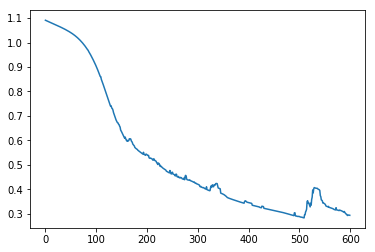

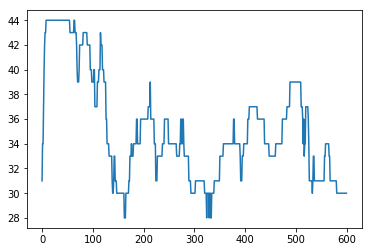

In [41]:
plt.plot(epoch_losses)
plt.show()
plt.plot(epoch_accuracies)

## Train mass model

In [27]:
train_loader, val_loader = prepare_dataset(exp1_trials, MASS_CLASS_COLS, normalise=True)

In [33]:
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

input_dim = 16   # input dimension
first_hidden_dim = 12  # hidden layer dimension
second_hidden_dim = 6     # number of hidden layers
output_dim = 3   # output dimension

model = ComplexRNNModel(input_dim, first_hidden_dim, second_hidden_dim, output_dim)
model = model.cuda()

error = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [34]:
model.train()

ComplexRNNModel(
  (lstm): LSTM(16, 12, batch_first=True)
  (lstm_2): LSTM(12, 6, batch_first=True)
  (fc): Linear(in_features=6, out_features=3, bias=True)
)

In [35]:
epoch_losses, epoch_accuracies = training_loop(model, optimizer, error, train_loader, val_loader, num_epochs=600)

  0%|          | 1/600 [00:00<04:23,  2.27it/s]

1.1045753955841064 tensor(34, device='cuda:0')


  0%|          | 2/600 [00:00<04:15,  2.34it/s]

1.103753685951233 tensor(33, device='cuda:0')


  0%|          | 3/600 [00:01<04:10,  2.38it/s]

1.1029480695724487 tensor(37, device='cuda:0')


  1%|          | 4/600 [00:01<04:07,  2.41it/s]

1.102159023284912 tensor(37, device='cuda:0')


  1%|          | 5/600 [00:02<04:05,  2.43it/s]

1.1013858318328857 tensor(42, device='cuda:0')


  1%|          | 6/600 [00:02<04:04,  2.43it/s]

1.1006278991699219 tensor(42, device='cuda:0')


  1%|          | 7/600 [00:02<04:03,  2.43it/s]

1.0998846292495728 tensor(42, device='cuda:0')


  1%|▏         | 8/600 [00:03<04:01,  2.45it/s]

1.099155306816101 tensor(43, device='cuda:0')


  2%|▏         | 9/600 [00:03<04:00,  2.46it/s]

1.0984387397766113 tensor(42, device='cuda:0')


  2%|▏         | 10/600 [00:04<04:00,  2.45it/s]

1.0977342128753662 tensor(43, device='cuda:0')


  2%|▏         | 11/600 [00:04<03:59,  2.46it/s]

1.0970406532287598 tensor(47, device='cuda:0')


  2%|▏         | 12/600 [00:04<03:52,  2.53it/s]

1.0963571071624756 tensor(47, device='cuda:0')


  2%|▏         | 13/600 [00:05<03:53,  2.52it/s]

1.095682144165039 tensor(49, device='cuda:0')


  2%|▏         | 14/600 [00:05<03:55,  2.49it/s]

1.0950148105621338 tensor(49, device='cuda:0')


  2%|▎         | 15/600 [00:06<03:55,  2.48it/s]

1.0943537950515747 tensor(47, device='cuda:0')


  3%|▎         | 16/600 [00:06<03:55,  2.48it/s]

1.0936977863311768 tensor(43, device='cuda:0')


  3%|▎         | 17/600 [00:06<03:55,  2.47it/s]

1.0930460691452026 tensor(43, device='cuda:0')


  3%|▎         | 18/600 [00:07<03:55,  2.47it/s]

1.0923969745635986 tensor(42, device='cuda:0')


  3%|▎         | 19/600 [00:07<03:55,  2.46it/s]

1.0917490720748901 tensor(43, device='cuda:0')


  3%|▎         | 20/600 [00:08<03:55,  2.46it/s]

1.0911012887954712 tensor(40, device='cuda:0')


  4%|▎         | 21/600 [00:08<03:55,  2.46it/s]

1.090451717376709 tensor(40, device='cuda:0')


  4%|▎         | 22/600 [00:08<03:54,  2.46it/s]

1.0897995233535767 tensor(40, device='cuda:0')


  4%|▍         | 23/600 [00:09<03:52,  2.48it/s]

1.0891430377960205 tensor(40, device='cuda:0')


  4%|▍         | 24/600 [00:09<03:48,  2.52it/s]

1.0884811878204346 tensor(39, device='cuda:0')


  4%|▍         | 25/600 [00:10<03:47,  2.53it/s]

1.0878119468688965 tensor(39, device='cuda:0')


  4%|▍         | 26/600 [00:10<03:47,  2.53it/s]

1.0871344804763794 tensor(39, device='cuda:0')


  4%|▍         | 27/600 [00:10<03:49,  2.50it/s]

1.0864472389221191 tensor(39, device='cuda:0')


  5%|▍         | 28/600 [00:11<03:47,  2.51it/s]

1.0857490301132202 tensor(36, device='cuda:0')


  5%|▍         | 29/600 [00:11<03:47,  2.51it/s]

1.085038423538208 tensor(36, device='cuda:0')


  5%|▌         | 30/600 [00:12<03:48,  2.50it/s]

1.0843143463134766 tensor(31, device='cuda:0')


  5%|▌         | 31/600 [00:12<03:38,  2.60it/s]

1.0835753679275513 tensor(31, device='cuda:0')


  5%|▌         | 32/600 [00:12<03:39,  2.59it/s]

1.082819938659668 tensor(31, device='cuda:0')


  6%|▌         | 33/600 [00:13<03:36,  2.62it/s]

1.082047462463379 tensor(31, device='cuda:0')


  6%|▌         | 34/600 [00:13<03:37,  2.61it/s]

1.08125638961792 tensor(31, device='cuda:0')


  6%|▌         | 35/600 [00:13<03:28,  2.70it/s]

1.0804455280303955 tensor(31, device='cuda:0')


  6%|▌         | 36/600 [00:14<03:31,  2.67it/s]

1.0796135663986206 tensor(31, device='cuda:0')


  6%|▌         | 37/600 [00:14<03:32,  2.65it/s]

1.0787593126296997 tensor(31, device='cuda:0')


  6%|▋         | 38/600 [00:15<03:33,  2.63it/s]

1.0778815746307373 tensor(31, device='cuda:0')


  6%|▋         | 39/600 [00:15<03:34,  2.62it/s]

1.076979398727417 tensor(31, device='cuda:0')


  7%|▋         | 40/600 [00:15<03:35,  2.60it/s]

1.076050877571106 tensor(33, device='cuda:0')


  7%|▋         | 41/600 [00:16<03:34,  2.61it/s]

1.0750958919525146 tensor(33, device='cuda:0')


  7%|▋         | 42/600 [00:16<03:25,  2.71it/s]

1.0741127729415894 tensor(33, device='cuda:0')


  7%|▋         | 43/600 [00:16<03:19,  2.79it/s]

1.0731008052825928 tensor(33, device='cuda:0')


  7%|▋         | 44/600 [00:17<03:23,  2.73it/s]

1.0720593929290771 tensor(33, device='cuda:0')


  8%|▊         | 45/600 [00:17<03:17,  2.81it/s]

1.0709880590438843 tensor(31, device='cuda:0')


  8%|▊         | 46/600 [00:18<03:21,  2.74it/s]

1.0698853731155396 tensor(31, device='cuda:0')


  8%|▊         | 47/600 [00:18<03:24,  2.70it/s]

1.0687516927719116 tensor(30, device='cuda:0')


  8%|▊         | 48/600 [00:18<03:26,  2.67it/s]

1.067585825920105 tensor(30, device='cuda:0')


  8%|▊         | 49/600 [00:19<03:28,  2.65it/s]

1.0663870573043823 tensor(30, device='cuda:0')


  8%|▊         | 50/600 [00:19<03:28,  2.63it/s]

1.0651534795761108 tensor(28, device='cuda:0')


  8%|▊         | 51/600 [00:19<03:27,  2.65it/s]

1.0638846158981323 tensor(28, device='cuda:0')


  9%|▊         | 52/600 [00:20<03:28,  2.62it/s]

1.0625782012939453 tensor(27, device='cuda:0')


  9%|▉         | 53/600 [00:20<03:20,  2.72it/s]

1.0612328052520752 tensor(27, device='cuda:0')


  9%|▉         | 54/600 [00:21<03:20,  2.72it/s]

1.0598464012145996 tensor(27, device='cuda:0')


  9%|▉         | 55/600 [00:21<03:22,  2.69it/s]

1.0584163665771484 tensor(30, device='cuda:0')


  9%|▉         | 56/600 [00:21<03:16,  2.77it/s]

1.0569405555725098 tensor(30, device='cuda:0')


 10%|▉         | 57/600 [00:22<03:19,  2.72it/s]

1.0554157495498657 tensor(30, device='cuda:0')


 10%|▉         | 58/600 [00:22<03:22,  2.68it/s]

1.0538396835327148 tensor(30, device='cuda:0')


 10%|▉         | 59/600 [00:22<03:24,  2.65it/s]

1.052208423614502 tensor(30, device='cuda:0')


 10%|█         | 60/600 [00:23<03:26,  2.62it/s]

1.0505191087722778 tensor(31, device='cuda:0')


 10%|█         | 61/600 [00:23<03:26,  2.61it/s]

1.0487688779830933 tensor(31, device='cuda:0')


 10%|█         | 62/600 [00:24<03:26,  2.60it/s]

1.0469543933868408 tensor(31, device='cuda:0')


 10%|█         | 63/600 [00:24<03:26,  2.60it/s]

1.0450735092163086 tensor(33, device='cuda:0')


 11%|█         | 64/600 [00:24<03:20,  2.67it/s]

1.0431240797042847 tensor(33, device='cuda:0')


 11%|█         | 65/600 [00:25<03:14,  2.75it/s]

1.0411043167114258 tensor(33, device='cuda:0')


 11%|█         | 66/600 [00:25<03:15,  2.74it/s]

1.0390137434005737 tensor(34, device='cuda:0')


 11%|█         | 67/600 [00:25<03:18,  2.69it/s]

1.0368512868881226 tensor(34, device='cuda:0')


 11%|█▏        | 68/600 [00:26<03:21,  2.65it/s]

1.0346180200576782 tensor(34, device='cuda:0')


 12%|█▏        | 69/600 [00:26<03:13,  2.74it/s]

1.0323134660720825 tensor(36, device='cuda:0')


 12%|█▏        | 70/600 [00:27<03:16,  2.69it/s]

1.0299392938613892 tensor(36, device='cuda:0')


 12%|█▏        | 71/600 [00:27<03:17,  2.68it/s]

1.0274953842163086 tensor(36, device='cuda:0')


 12%|█▏        | 72/600 [00:27<03:19,  2.65it/s]

1.02498197555542 tensor(36, device='cuda:0')


 12%|█▏        | 73/600 [00:28<03:20,  2.63it/s]

1.0224000215530396 tensor(37, device='cuda:0')


 12%|█▏        | 74/600 [00:28<03:21,  2.61it/s]

1.019749641418457 tensor(37, device='cuda:0')


 12%|█▎        | 75/600 [00:28<03:22,  2.60it/s]

1.0170323848724365 tensor(39, device='cuda:0')


 13%|█▎        | 76/600 [00:29<03:21,  2.60it/s]

1.0142487287521362 tensor(40, device='cuda:0')


 13%|█▎        | 77/600 [00:29<03:21,  2.59it/s]

1.0113959312438965 tensor(40, device='cuda:0')


 13%|█▎        | 78/600 [00:30<03:22,  2.58it/s]

1.0084670782089233 tensor(39, device='cuda:0')


 13%|█▎        | 79/600 [00:30<03:15,  2.66it/s]

1.005452275276184 tensor(37, device='cuda:0')


 13%|█▎        | 80/600 [00:30<03:10,  2.73it/s]

1.0023431777954102 tensor(39, device='cuda:0')


 14%|█▎        | 81/600 [00:31<03:13,  2.68it/s]

0.999135434627533 tensor(39, device='cuda:0')


 14%|█▎        | 82/600 [00:31<03:07,  2.76it/s]

0.9958266019821167 tensor(36, device='cuda:0')


 14%|█▍        | 83/600 [00:31<03:10,  2.71it/s]

0.9924120903015137 tensor(36, device='cuda:0')


 14%|█▍        | 84/600 [00:32<03:12,  2.68it/s]

0.9889031648635864 tensor(39, device='cuda:0')


 14%|█▍        | 85/600 [00:32<03:14,  2.65it/s]

0.9853191375732422 tensor(37, device='cuda:0')


 14%|█▍        | 86/600 [00:33<03:13,  2.66it/s]

0.9816657900810242 tensor(37, device='cuda:0')


 14%|█▍        | 87/600 [00:33<03:15,  2.63it/s]

0.9779618382453918 tensor(37, device='cuda:0')


 15%|█▍        | 88/600 [00:33<03:15,  2.62it/s]

0.974154531955719 tensor(39, device='cuda:0')


 15%|█▍        | 89/600 [00:34<03:16,  2.60it/s]

0.9702288508415222 tensor(39, device='cuda:0')


 15%|█▌        | 90/600 [00:34<03:19,  2.56it/s]

0.9662408232688904 tensor(39, device='cuda:0')


 15%|█▌        | 91/600 [00:35<03:21,  2.53it/s]

0.9621695280075073 tensor(39, device='cuda:0')


 15%|█▌        | 92/600 [00:35<03:19,  2.55it/s]

0.9582438468933105 tensor(42, device='cuda:0')


 16%|█▌        | 93/600 [00:35<03:16,  2.58it/s]

0.9542741179466248 tensor(42, device='cuda:0')


 16%|█▌        | 94/600 [00:36<03:16,  2.58it/s]

0.9502066373825073 tensor(43, device='cuda:0')


 16%|█▌        | 95/600 [00:36<03:17,  2.56it/s]

0.9460835456848145 tensor(46, device='cuda:0')


 16%|█▌        | 96/600 [00:36<03:17,  2.55it/s]

0.9419574737548828 tensor(46, device='cuda:0')


 16%|█▌        | 97/600 [00:37<03:16,  2.57it/s]

0.9379057884216309 tensor(46, device='cuda:0')


 16%|█▋        | 98/600 [00:37<03:15,  2.56it/s]

0.9337608218193054 tensor(46, device='cuda:0')


 16%|█▋        | 99/600 [00:38<03:17,  2.54it/s]

0.9297091364860535 tensor(46, device='cuda:0')


 17%|█▋        | 100/600 [00:38<03:18,  2.52it/s]

0.9256691932678223 tensor(46, device='cuda:0')


 17%|█▋        | 101/600 [00:38<03:20,  2.49it/s]

0.9216550588607788 tensor(46, device='cuda:0')


 17%|█▋        | 102/600 [00:39<03:19,  2.50it/s]

0.9176568984985352 tensor(46, device='cuda:0')


 17%|█▋        | 103/600 [00:39<03:18,  2.50it/s]

0.9136723875999451 tensor(46, device='cuda:0')


 17%|█▋        | 104/600 [00:40<03:14,  2.54it/s]

0.9096341133117676 tensor(47, device='cuda:0')


 18%|█▊        | 105/600 [00:40<03:13,  2.56it/s]

0.9055830836296082 tensor(49, device='cuda:0')


 18%|█▊        | 106/600 [00:40<03:14,  2.54it/s]

0.9034357070922852 tensor(47, device='cuda:0')


 18%|█▊        | 107/600 [00:41<03:13,  2.55it/s]

0.9005728960037231 tensor(46, device='cuda:0')


 18%|█▊        | 108/600 [00:41<03:09,  2.59it/s]

0.896875262260437 tensor(46, device='cuda:0')


 18%|█▊        | 109/600 [00:42<03:09,  2.59it/s]

0.893198549747467 tensor(44, device='cuda:0')


 18%|█▊        | 110/600 [00:42<03:09,  2.59it/s]

0.8894018530845642 tensor(44, device='cuda:0')


 18%|█▊        | 111/600 [00:42<03:09,  2.58it/s]

0.884684145450592 tensor(42, device='cuda:0')


 19%|█▊        | 112/600 [00:43<03:02,  2.67it/s]

0.8812837600708008 tensor(40, device='cuda:0')


 19%|█▉        | 113/600 [00:43<03:01,  2.68it/s]

0.8777705430984497 tensor(42, device='cuda:0')


 19%|█▉        | 114/600 [00:43<03:03,  2.65it/s]

0.8763108849525452 tensor(43, device='cuda:0')


 19%|█▉        | 115/600 [00:44<03:04,  2.62it/s]

0.8706055879592896 tensor(43, device='cuda:0')


 19%|█▉        | 116/600 [00:44<03:05,  2.61it/s]

0.8670674562454224 tensor(43, device='cuda:0')


 20%|█▉        | 117/600 [00:45<03:05,  2.61it/s]

0.8636831641197205 tensor(42, device='cuda:0')


 20%|█▉        | 118/600 [00:45<03:03,  2.63it/s]

0.8634196519851685 tensor(40, device='cuda:0')


 20%|█▉        | 119/600 [00:45<03:04,  2.61it/s]

0.8641462922096252 tensor(40, device='cuda:0')


 20%|██        | 120/600 [00:46<03:04,  2.60it/s]

0.8627505302429199 tensor(42, device='cuda:0')


 20%|██        | 121/600 [00:46<03:04,  2.60it/s]

0.8608457446098328 tensor(43, device='cuda:0')


 20%|██        | 122/600 [00:47<03:04,  2.59it/s]

0.8587233424186707 tensor(43, device='cuda:0')


 20%|██        | 123/600 [00:47<02:57,  2.68it/s]

0.8565472364425659 tensor(43, device='cuda:0')


 21%|██        | 124/600 [00:47<02:59,  2.65it/s]

0.8541498780250549 tensor(44, device='cuda:0')


 21%|██        | 125/600 [00:48<03:00,  2.63it/s]

0.8515233993530273 tensor(44, device='cuda:0')


 21%|██        | 126/600 [00:48<02:54,  2.72it/s]

0.8487292528152466 tensor(44, device='cuda:0')


 21%|██        | 127/600 [00:48<02:54,  2.71it/s]

0.8458178043365479 tensor(44, device='cuda:0')


 21%|██▏       | 128/600 [00:49<02:57,  2.67it/s]

0.842667281627655 tensor(43, device='cuda:0')


 22%|██▏       | 129/600 [00:49<02:51,  2.75it/s]

0.8388681411743164 tensor(42, device='cuda:0')


 22%|██▏       | 130/600 [00:49<02:53,  2.70it/s]

0.8351474404335022 tensor(42, device='cuda:0')


 22%|██▏       | 131/600 [00:50<02:55,  2.67it/s]

0.8323727250099182 tensor(42, device='cuda:0')


 22%|██▏       | 132/600 [00:50<02:57,  2.63it/s]

0.8295442461967468 tensor(42, device='cuda:0')


 22%|██▏       | 133/600 [00:51<02:58,  2.62it/s]

0.8267090320587158 tensor(43, device='cuda:0')


 22%|██▏       | 134/600 [00:51<02:58,  2.62it/s]

0.82381272315979 tensor(39, device='cuda:0')


 22%|██▎       | 135/600 [00:51<02:55,  2.64it/s]

0.8207831382751465 tensor(39, device='cuda:0')


 23%|██▎       | 136/600 [00:52<02:57,  2.62it/s]

0.8176130056381226 tensor(39, device='cuda:0')


 23%|██▎       | 137/600 [00:52<02:57,  2.60it/s]

0.8138098120689392 tensor(39, device='cuda:0')


 23%|██▎       | 138/600 [00:53<02:57,  2.61it/s]

0.8103517293930054 tensor(37, device='cuda:0')


 23%|██▎       | 139/600 [00:53<02:50,  2.70it/s]

0.807183027267456 tensor(37, device='cuda:0')


 23%|██▎       | 140/600 [00:53<02:52,  2.66it/s]

0.8040662407875061 tensor(36, device='cuda:0')


 24%|██▎       | 141/600 [00:54<02:54,  2.63it/s]

0.8009260892868042 tensor(36, device='cuda:0')


 24%|██▎       | 142/600 [00:54<02:54,  2.62it/s]

0.7977483868598938 tensor(36, device='cuda:0')


 24%|██▍       | 143/600 [00:54<02:55,  2.60it/s]

0.7944163680076599 tensor(36, device='cuda:0')


 24%|██▍       | 144/600 [00:55<02:56,  2.59it/s]

0.7910043597221375 tensor(37, device='cuda:0')


 24%|██▍       | 145/600 [00:55<02:55,  2.59it/s]

0.787618100643158 tensor(37, device='cuda:0')


 24%|██▍       | 146/600 [00:56<02:53,  2.62it/s]

0.7843624353408813 tensor(37, device='cuda:0')


 24%|██▍       | 147/600 [00:56<02:53,  2.61it/s]

0.7812022566795349 tensor(37, device='cuda:0')


 25%|██▍       | 148/600 [00:56<02:47,  2.70it/s]

0.7781246900558472 tensor(37, device='cuda:0')


 25%|██▍       | 149/600 [00:57<02:49,  2.66it/s]

0.7750774025917053 tensor(37, device='cuda:0')


 25%|██▌       | 150/600 [00:57<02:51,  2.62it/s]

0.7720282673835754 tensor(37, device='cuda:0')


 25%|██▌       | 151/600 [00:57<02:50,  2.63it/s]

0.7695308923721313 tensor(37, device='cuda:0')


 25%|██▌       | 152/600 [00:58<02:50,  2.62it/s]

0.7665929198265076 tensor(37, device='cuda:0')


 26%|██▌       | 153/600 [00:58<02:51,  2.60it/s]

0.7636687159538269 tensor(37, device='cuda:0')


 26%|██▌       | 154/600 [00:59<02:52,  2.59it/s]

0.7607460618019104 tensor(37, device='cuda:0')


 26%|██▌       | 155/600 [00:59<02:45,  2.68it/s]

0.757861852645874 tensor(37, device='cuda:0')


 26%|██▌       | 156/600 [00:59<02:47,  2.65it/s]

0.7549889087677002 tensor(37, device='cuda:0')


 26%|██▌       | 157/600 [01:00<02:42,  2.72it/s]

0.7521275281906128 tensor(37, device='cuda:0')


 26%|██▋       | 158/600 [01:00<02:45,  2.67it/s]

0.7499890923500061 tensor(37, device='cuda:0')


 26%|██▋       | 159/600 [01:01<02:47,  2.64it/s]

0.7472659349441528 tensor(37, device='cuda:0')


 27%|██▋       | 160/600 [01:01<02:47,  2.63it/s]

0.7445611953735352 tensor(37, device='cuda:0')


 27%|██▋       | 161/600 [01:01<02:49,  2.60it/s]

0.7490093111991882 tensor(37, device='cuda:0')


 27%|██▋       | 162/600 [01:02<02:50,  2.57it/s]

0.7456777691841125 tensor(37, device='cuda:0')


 27%|██▋       | 163/600 [01:02<02:52,  2.53it/s]

0.7385548949241638 tensor(37, device='cuda:0')


 27%|██▋       | 164/600 [01:02<02:51,  2.54it/s]

0.7361526489257812 tensor(36, device='cuda:0')


 28%|██▊       | 165/600 [01:03<02:51,  2.53it/s]

0.7335491180419922 tensor(36, device='cuda:0')


 28%|██▊       | 166/600 [01:03<02:51,  2.53it/s]

0.730666995048523 tensor(36, device='cuda:0')


 28%|██▊       | 167/600 [01:04<02:52,  2.51it/s]

0.7284775376319885 tensor(37, device='cuda:0')


 28%|██▊       | 168/600 [01:04<02:52,  2.51it/s]

0.7261534333229065 tensor(37, device='cuda:0')


 28%|██▊       | 169/600 [01:04<02:52,  2.49it/s]

0.7235047817230225 tensor(39, device='cuda:0')


 28%|██▊       | 170/600 [01:05<02:52,  2.49it/s]

0.7208991646766663 tensor(39, device='cuda:0')


 28%|██▊       | 171/600 [01:05<02:50,  2.52it/s]

0.7184588313102722 tensor(37, device='cuda:0')


 29%|██▊       | 172/600 [01:06<02:49,  2.53it/s]

0.7162191867828369 tensor(37, device='cuda:0')


 29%|██▉       | 173/600 [01:06<02:47,  2.55it/s]

0.7139291167259216 tensor(37, device='cuda:0')


 29%|██▉       | 174/600 [01:06<02:45,  2.57it/s]

0.7117213606834412 tensor(37, device='cuda:0')


 29%|██▉       | 175/600 [01:07<02:43,  2.59it/s]

0.709621012210846 tensor(37, device='cuda:0')


 29%|██▉       | 176/600 [01:07<02:43,  2.59it/s]

0.707457959651947 tensor(37, device='cuda:0')


 30%|██▉       | 177/600 [01:08<02:37,  2.68it/s]

0.705453634262085 tensor(37, device='cuda:0')


 30%|██▉       | 178/600 [01:08<02:38,  2.67it/s]

0.7032331228256226 tensor(37, device='cuda:0')


 30%|██▉       | 179/600 [01:08<02:39,  2.64it/s]

0.7009655237197876 tensor(37, device='cuda:0')


 30%|███       | 180/600 [01:09<02:40,  2.62it/s]

0.6987057328224182 tensor(37, device='cuda:0')


 30%|███       | 181/600 [01:09<02:34,  2.70it/s]

0.6963377594947815 tensor(37, device='cuda:0')


 30%|███       | 182/600 [01:09<02:35,  2.69it/s]

0.6890352368354797 tensor(37, device='cuda:0')


 30%|███       | 183/600 [01:10<02:31,  2.76it/s]

0.686068594455719 tensor(37, device='cuda:0')


 31%|███       | 184/600 [01:10<02:32,  2.74it/s]

0.6822962164878845 tensor(37, device='cuda:0')


 31%|███       | 185/600 [01:11<02:34,  2.69it/s]

0.6794695258140564 tensor(37, device='cuda:0')


 31%|███       | 186/600 [01:11<02:30,  2.75it/s]

0.6773088574409485 tensor(37, device='cuda:0')


 31%|███       | 187/600 [01:11<02:33,  2.69it/s]

0.6749769449234009 tensor(37, device='cuda:0')


 31%|███▏      | 188/600 [01:12<02:29,  2.75it/s]

0.6726083159446716 tensor(37, device='cuda:0')


 32%|███▏      | 189/600 [01:12<02:32,  2.69it/s]

0.6703798174858093 tensor(37, device='cuda:0')


 32%|███▏      | 190/600 [01:12<02:33,  2.66it/s]

0.6682258248329163 tensor(37, device='cuda:0')


 32%|███▏      | 191/600 [01:13<02:35,  2.64it/s]

0.6670394539833069 tensor(37, device='cuda:0')


 32%|███▏      | 192/600 [01:13<02:34,  2.65it/s]

0.6648270487785339 tensor(37, device='cuda:0')


 32%|███▏      | 193/600 [01:14<02:34,  2.63it/s]

0.6651433706283569 tensor(37, device='cuda:0')


 32%|███▏      | 194/600 [01:14<02:29,  2.71it/s]

0.6650116443634033 tensor(37, device='cuda:0')


 32%|███▎      | 195/600 [01:14<02:31,  2.67it/s]

0.6641110181808472 tensor(39, device='cuda:0')


 33%|███▎      | 196/600 [01:15<02:27,  2.74it/s]

0.6600540280342102 tensor(39, device='cuda:0')


 33%|███▎      | 197/600 [01:15<02:29,  2.69it/s]

0.6577594876289368 tensor(39, device='cuda:0')


 33%|███▎      | 198/600 [01:15<02:31,  2.65it/s]

0.6554046869277954 tensor(39, device='cuda:0')


 33%|███▎      | 199/600 [01:16<02:26,  2.73it/s]

0.653124213218689 tensor(39, device='cuda:0')


 33%|███▎      | 200/600 [01:16<02:29,  2.68it/s]

0.6509597897529602 tensor(39, device='cuda:0')


 34%|███▎      | 201/600 [01:16<02:25,  2.75it/s]

0.6489279866218567 tensor(39, device='cuda:0')


 34%|███▎      | 202/600 [01:17<02:27,  2.71it/s]

0.647147536277771 tensor(39, device='cuda:0')


 34%|███▍      | 203/600 [01:17<02:29,  2.66it/s]

0.6451640725135803 tensor(37, device='cuda:0')


 34%|███▍      | 204/600 [01:18<02:25,  2.73it/s]

0.6433616280555725 tensor(36, device='cuda:0')


 34%|███▍      | 205/600 [01:18<02:25,  2.71it/s]

0.6414798498153687 tensor(36, device='cuda:0')


 34%|███▍      | 206/600 [01:18<02:27,  2.67it/s]

0.6397134065628052 tensor(36, device='cuda:0')


 34%|███▍      | 207/600 [01:19<02:29,  2.64it/s]

0.6377832293510437 tensor(36, device='cuda:0')


 35%|███▍      | 208/600 [01:19<02:30,  2.61it/s]

0.6357863545417786 tensor(39, device='cuda:0')


 35%|███▍      | 209/600 [01:19<02:24,  2.70it/s]

0.6338828206062317 tensor(39, device='cuda:0')


 35%|███▌      | 210/600 [01:20<02:21,  2.76it/s]

0.6315378546714783 tensor(39, device='cuda:0')


 35%|███▌      | 211/600 [01:20<02:23,  2.70it/s]

0.6294764876365662 tensor(39, device='cuda:0')


 35%|███▌      | 212/600 [01:21<02:24,  2.69it/s]

0.6274063587188721 tensor(40, device='cuda:0')


 36%|███▌      | 213/600 [01:21<02:24,  2.67it/s]

0.6255525350570679 tensor(40, device='cuda:0')


 36%|███▌      | 214/600 [01:21<02:27,  2.61it/s]

0.6235091686248779 tensor(40, device='cuda:0')


 36%|███▌      | 215/600 [01:22<02:22,  2.70it/s]

0.6215697526931763 tensor(40, device='cuda:0')


 36%|███▌      | 216/600 [01:22<02:23,  2.68it/s]

0.6195641756057739 tensor(40, device='cuda:0')


 36%|███▌      | 217/600 [01:22<02:23,  2.67it/s]

0.6176327466964722 tensor(39, device='cuda:0')


 36%|███▋      | 218/600 [01:23<02:24,  2.65it/s]

0.6156821250915527 tensor(39, device='cuda:0')


 36%|███▋      | 219/600 [01:23<02:19,  2.73it/s]

0.6136775612831116 tensor(39, device='cuda:0')


 37%|███▋      | 220/600 [01:24<02:21,  2.68it/s]

0.611784040927887 tensor(39, device='cuda:0')


 37%|███▋      | 221/600 [01:24<02:17,  2.75it/s]

0.6101663112640381 tensor(39, device='cuda:0')


 37%|███▋      | 222/600 [01:24<02:20,  2.69it/s]

0.6090649962425232 tensor(39, device='cuda:0')


 37%|███▋      | 223/600 [01:25<02:21,  2.66it/s]

0.6074271202087402 tensor(40, device='cuda:0')


 37%|███▋      | 224/600 [01:25<02:17,  2.73it/s]

0.6054106950759888 tensor(39, device='cuda:0')


 38%|███▊      | 225/600 [01:25<02:20,  2.68it/s]

0.6037028431892395 tensor(40, device='cuda:0')


 38%|███▊      | 226/600 [01:26<02:15,  2.75it/s]

0.6014311909675598 tensor(39, device='cuda:0')


 38%|███▊      | 227/600 [01:26<02:17,  2.71it/s]

0.5994956493377686 tensor(39, device='cuda:0')


 38%|███▊      | 228/600 [01:27<02:21,  2.64it/s]

0.5975878238677979 tensor(40, device='cuda:0')


 38%|███▊      | 229/600 [01:27<02:23,  2.58it/s]

0.5955609083175659 tensor(40, device='cuda:0')


 38%|███▊      | 230/600 [01:27<02:23,  2.58it/s]

0.5930666923522949 tensor(40, device='cuda:0')


 38%|███▊      | 231/600 [01:28<02:25,  2.54it/s]

0.6002484560012817 tensor(40, device='cuda:0')


 39%|███▊      | 232/600 [01:28<02:25,  2.52it/s]

0.5941140055656433 tensor(39, device='cuda:0')


 39%|███▉      | 233/600 [01:29<02:26,  2.51it/s]

0.5927134156227112 tensor(39, device='cuda:0')


 39%|███▉      | 234/600 [01:29<02:25,  2.51it/s]

0.5924074649810791 tensor(39, device='cuda:0')


 39%|███▉      | 235/600 [01:29<02:25,  2.50it/s]

0.5890514254570007 tensor(39, device='cuda:0')


 39%|███▉      | 236/600 [01:30<02:24,  2.51it/s]

0.5867723822593689 tensor(39, device='cuda:0')


 40%|███▉      | 237/600 [01:30<02:26,  2.48it/s]

0.5885031223297119 tensor(39, device='cuda:0')


 40%|███▉      | 238/600 [01:31<02:24,  2.50it/s]

0.5871737003326416 tensor(39, device='cuda:0')


 40%|███▉      | 239/600 [01:31<02:23,  2.52it/s]

0.5849114656448364 tensor(39, device='cuda:0')


 40%|████      | 240/600 [01:31<02:22,  2.53it/s]

0.5822983384132385 tensor(39, device='cuda:0')


 40%|████      | 241/600 [01:32<02:20,  2.55it/s]

0.5794260501861572 tensor(42, device='cuda:0')


 40%|████      | 242/600 [01:32<02:20,  2.55it/s]

0.5767508745193481 tensor(40, device='cuda:0')


 40%|████      | 243/600 [01:32<02:19,  2.55it/s]

0.5741276741027832 tensor(40, device='cuda:0')


 41%|████      | 244/600 [01:33<02:14,  2.65it/s]

0.5722593665122986 tensor(40, device='cuda:0')


 41%|████      | 245/600 [01:33<02:15,  2.63it/s]

0.5703306794166565 tensor(39, device='cuda:0')


 41%|████      | 246/600 [01:34<02:10,  2.71it/s]

0.5680493116378784 tensor(39, device='cuda:0')


 41%|████      | 247/600 [01:34<02:12,  2.66it/s]

0.5660723447799683 tensor(37, device='cuda:0')


 41%|████▏     | 248/600 [01:34<02:13,  2.64it/s]

0.5625731945037842 tensor(39, device='cuda:0')


 42%|████▏     | 249/600 [01:35<02:14,  2.61it/s]

0.5600430965423584 tensor(39, device='cuda:0')


 42%|████▏     | 250/600 [01:35<02:14,  2.60it/s]

0.5571344494819641 tensor(37, device='cuda:0')


 42%|████▏     | 251/600 [01:36<02:14,  2.60it/s]

0.5544142723083496 tensor(39, device='cuda:0')


 42%|████▏     | 252/600 [01:36<02:12,  2.62it/s]

0.5522481203079224 tensor(37, device='cuda:0')


 42%|████▏     | 253/600 [01:36<02:13,  2.60it/s]

0.5501869916915894 tensor(37, device='cuda:0')


 42%|████▏     | 254/600 [01:37<02:08,  2.69it/s]

0.548187255859375 tensor(37, device='cuda:0')


 42%|████▎     | 255/600 [01:37<02:08,  2.68it/s]

0.5461822748184204 tensor(37, device='cuda:0')


 43%|████▎     | 256/600 [01:37<02:08,  2.68it/s]

0.5438998341560364 tensor(37, device='cuda:0')


 43%|████▎     | 257/600 [01:38<02:09,  2.64it/s]

0.5419067740440369 tensor(37, device='cuda:0')


 43%|████▎     | 258/600 [01:38<02:06,  2.71it/s]

0.5401280522346497 tensor(37, device='cuda:0')


 43%|████▎     | 259/600 [01:38<02:06,  2.69it/s]

0.5385450720787048 tensor(37, device='cuda:0')


 43%|████▎     | 260/600 [01:39<02:08,  2.65it/s]

0.5370239019393921 tensor(37, device='cuda:0')


 44%|████▎     | 261/600 [01:39<02:04,  2.72it/s]

0.5355486273765564 tensor(37, device='cuda:0')


 44%|████▎     | 262/600 [01:40<02:05,  2.70it/s]

0.5417942404747009 tensor(37, device='cuda:0')


 44%|████▍     | 263/600 [01:40<02:05,  2.68it/s]

0.5403243899345398 tensor(37, device='cuda:0')


 44%|████▍     | 264/600 [01:40<02:06,  2.65it/s]

0.5386261940002441 tensor(37, device='cuda:0')


 44%|████▍     | 265/600 [01:41<02:07,  2.63it/s]

0.5369001030921936 tensor(37, device='cuda:0')


 44%|████▍     | 266/600 [01:41<02:07,  2.61it/s]

0.535217821598053 tensor(37, device='cuda:0')


 44%|████▍     | 267/600 [01:42<02:06,  2.63it/s]

0.5257962942123413 tensor(37, device='cuda:0')


 45%|████▍     | 268/600 [01:42<02:05,  2.64it/s]

0.524213969707489 tensor(37, device='cuda:0')


 45%|████▍     | 269/600 [01:42<02:06,  2.62it/s]

0.5224700570106506 tensor(37, device='cuda:0')


 45%|████▌     | 270/600 [01:43<02:02,  2.70it/s]

0.5200896859169006 tensor(37, device='cuda:0')


 45%|████▌     | 271/600 [01:43<02:02,  2.69it/s]

0.518480658531189 tensor(37, device='cuda:0')


 45%|████▌     | 272/600 [01:43<02:02,  2.68it/s]

0.5168945789337158 tensor(36, device='cuda:0')


 46%|████▌     | 273/600 [01:44<02:03,  2.65it/s]

0.5153173208236694 tensor(36, device='cuda:0')


 46%|████▌     | 274/600 [01:44<02:00,  2.72it/s]

0.5136313438415527 tensor(36, device='cuda:0')


 46%|████▌     | 275/600 [01:44<02:01,  2.67it/s]

0.5120491981506348 tensor(36, device='cuda:0')


 46%|████▌     | 276/600 [01:45<02:02,  2.65it/s]

0.5105078816413879 tensor(36, device='cuda:0')


 46%|████▌     | 277/600 [01:45<02:04,  2.60it/s]

0.5088947415351868 tensor(36, device='cuda:0')


 46%|████▋     | 278/600 [01:46<02:04,  2.59it/s]

0.507107138633728 tensor(36, device='cuda:0')


 46%|████▋     | 279/600 [01:46<02:04,  2.58it/s]

0.5052428245544434 tensor(37, device='cuda:0')


 47%|████▋     | 280/600 [01:46<02:03,  2.59it/s]

0.5032863616943359 tensor(36, device='cuda:0')


 47%|████▋     | 281/600 [01:47<01:59,  2.67it/s]

0.5010592937469482 tensor(37, device='cuda:0')


 47%|████▋     | 282/600 [01:47<02:00,  2.65it/s]

0.49936574697494507 tensor(37, device='cuda:0')


 47%|████▋     | 283/600 [01:48<01:56,  2.72it/s]

0.49785956740379333 tensor(39, device='cuda:0')


 47%|████▋     | 284/600 [01:48<01:57,  2.70it/s]

0.49643751978874207 tensor(37, device='cuda:0')


 48%|████▊     | 285/600 [01:48<01:58,  2.67it/s]

0.49499595165252686 tensor(37, device='cuda:0')


 48%|████▊     | 286/600 [01:49<01:58,  2.64it/s]

0.49354153871536255 tensor(39, device='cuda:0')


 48%|████▊     | 287/600 [01:49<01:59,  2.62it/s]

0.492079496383667 tensor(40, device='cuda:0')


 48%|████▊     | 288/600 [01:49<01:55,  2.70it/s]

0.4907178282737732 tensor(40, device='cuda:0')


 48%|████▊     | 289/600 [01:50<01:56,  2.66it/s]

0.4986532926559448 tensor(40, device='cuda:0')


 48%|████▊     | 290/600 [01:50<01:53,  2.73it/s]

0.4972882568836212 tensor(40, device='cuda:0')


 48%|████▊     | 291/600 [01:51<01:55,  2.68it/s]

0.49572423100471497 tensor(42, device='cuda:0')


 49%|████▊     | 292/600 [01:51<01:52,  2.75it/s]

0.4939444363117218 tensor(42, device='cuda:0')


 49%|████▉     | 293/600 [01:51<01:54,  2.69it/s]

0.4922405183315277 tensor(42, device='cuda:0')


 49%|████▉     | 294/600 [01:52<01:55,  2.65it/s]

0.4911096692085266 tensor(42, device='cuda:0')


 49%|████▉     | 295/600 [01:52<01:55,  2.63it/s]

0.48934808373451233 tensor(40, device='cuda:0')


 49%|████▉     | 296/600 [01:52<01:56,  2.61it/s]

0.4883858859539032 tensor(42, device='cuda:0')


 50%|████▉     | 297/600 [01:53<01:56,  2.60it/s]

0.4873489439487457 tensor(42, device='cuda:0')


 50%|████▉     | 298/600 [01:53<01:56,  2.60it/s]

0.47772806882858276 tensor(42, device='cuda:0')


 50%|████▉     | 299/600 [01:54<01:56,  2.59it/s]

0.4765813946723938 tensor(42, device='cuda:0')


 50%|█████     | 300/600 [01:54<01:56,  2.58it/s]

0.47542598843574524 tensor(42, device='cuda:0')


 50%|█████     | 301/600 [01:54<01:55,  2.58it/s]

0.4742220640182495 tensor(42, device='cuda:0')


 50%|█████     | 302/600 [01:55<01:55,  2.59it/s]

0.4728972613811493 tensor(42, device='cuda:0')


 50%|█████     | 303/600 [01:55<01:55,  2.58it/s]

0.4691554605960846 tensor(42, device='cuda:0')


 51%|█████     | 304/600 [01:56<01:55,  2.56it/s]

0.4667125344276428 tensor(43, device='cuda:0')


 51%|█████     | 305/600 [01:56<01:55,  2.55it/s]

0.4660557210445404 tensor(43, device='cuda:0')


 51%|█████     | 306/600 [01:56<01:55,  2.55it/s]

0.4751785397529602 tensor(43, device='cuda:0')


 51%|█████     | 307/600 [01:57<01:55,  2.54it/s]

0.47878506779670715 tensor(42, device='cuda:0')


 51%|█████▏    | 308/600 [01:57<01:56,  2.51it/s]

0.47365838289260864 tensor(42, device='cuda:0')


 52%|█████▏    | 309/600 [01:58<01:56,  2.49it/s]

0.4728889465332031 tensor(42, device='cuda:0')


 52%|█████▏    | 310/600 [01:58<01:54,  2.52it/s]

0.4717079699039459 tensor(42, device='cuda:0')


 52%|█████▏    | 311/600 [01:58<01:53,  2.55it/s]

0.47025588154792786 tensor(42, device='cuda:0')


 52%|█████▏    | 312/600 [01:59<01:51,  2.58it/s]

0.4689907133579254 tensor(43, device='cuda:0')


 52%|█████▏    | 313/600 [01:59<01:52,  2.54it/s]

0.4684898853302002 tensor(43, device='cuda:0')


 52%|█████▏    | 314/600 [01:59<01:52,  2.54it/s]

0.4663834273815155 tensor(43, device='cuda:0')


 52%|█████▎    | 315/600 [02:00<01:53,  2.52it/s]

0.46525025367736816 tensor(43, device='cuda:0')


 53%|█████▎    | 316/600 [02:00<01:53,  2.50it/s]

0.4557385742664337 tensor(43, device='cuda:0')


 53%|█████▎    | 317/600 [02:01<01:54,  2.48it/s]

0.45466849207878113 tensor(43, device='cuda:0')


 53%|█████▎    | 318/600 [02:01<01:49,  2.57it/s]

0.45352602005004883 tensor(43, device='cuda:0')


 53%|█████▎    | 319/600 [02:01<01:50,  2.55it/s]

0.4518855810165405 tensor(42, device='cuda:0')


 53%|█████▎    | 320/600 [02:02<01:50,  2.54it/s]

0.45086076855659485 tensor(42, device='cuda:0')


 54%|█████▎    | 321/600 [02:02<01:49,  2.54it/s]

0.4498160779476166 tensor(40, device='cuda:0')


 54%|█████▎    | 322/600 [02:03<01:50,  2.51it/s]

0.4487496614456177 tensor(42, device='cuda:0')


 54%|█████▍    | 323/600 [02:03<01:50,  2.51it/s]

0.44777944684028625 tensor(40, device='cuda:0')


 54%|█████▍    | 324/600 [02:03<01:50,  2.50it/s]

0.4467090666294098 tensor(40, device='cuda:0')


 54%|█████▍    | 325/600 [02:04<01:50,  2.50it/s]

0.44569912552833557 tensor(40, device='cuda:0')


 54%|█████▍    | 326/600 [02:04<01:51,  2.47it/s]

0.4445578157901764 tensor(40, device='cuda:0')


 55%|█████▍    | 327/600 [02:05<01:51,  2.45it/s]

0.4433695375919342 tensor(42, device='cuda:0')


 55%|█████▍    | 328/600 [02:05<01:50,  2.45it/s]

0.44211679697036743 tensor(42, device='cuda:0')


 55%|█████▍    | 329/600 [02:06<01:51,  2.43it/s]

0.4408765435218811 tensor(42, device='cuda:0')


 55%|█████▌    | 330/600 [02:06<01:50,  2.43it/s]

0.43968498706817627 tensor(40, device='cuda:0')


 55%|█████▌    | 331/600 [02:06<01:50,  2.43it/s]

0.4388447701931 tensor(42, device='cuda:0')


 55%|█████▌    | 332/600 [02:07<01:49,  2.44it/s]

0.45591041445732117 tensor(43, device='cuda:0')


 56%|█████▌    | 333/600 [02:07<01:48,  2.46it/s]

0.44011425971984863 tensor(43, device='cuda:0')


 56%|█████▌    | 334/600 [02:08<01:48,  2.44it/s]

0.43862593173980713 tensor(43, device='cuda:0')


 56%|█████▌    | 335/600 [02:08<01:48,  2.45it/s]

0.4374132752418518 tensor(44, device='cuda:0')


 56%|█████▌    | 336/600 [02:08<01:47,  2.45it/s]

0.43643489480018616 tensor(44, device='cuda:0')


 56%|█████▌    | 337/600 [02:09<01:47,  2.45it/s]

0.43577027320861816 tensor(44, device='cuda:0')


 56%|█████▋    | 338/600 [02:09<01:42,  2.55it/s]

0.43480610847473145 tensor(44, device='cuda:0')


 56%|█████▋    | 339/600 [02:10<01:43,  2.52it/s]

0.43394961953163147 tensor(44, device='cuda:0')


 57%|█████▋    | 340/600 [02:10<01:42,  2.53it/s]

0.4328872859477997 tensor(44, device='cuda:0')


 57%|█████▋    | 341/600 [02:10<01:42,  2.54it/s]

0.4317587912082672 tensor(44, device='cuda:0')


 57%|█████▋    | 342/600 [02:11<01:41,  2.53it/s]

0.4306861460208893 tensor(44, device='cuda:0')


 57%|█████▋    | 343/600 [02:11<01:41,  2.52it/s]

0.42965197563171387 tensor(44, device='cuda:0')


 57%|█████▋    | 344/600 [02:11<01:39,  2.57it/s]

0.4286559522151947 tensor(44, device='cuda:0')


 57%|█████▊    | 345/600 [02:12<01:37,  2.60it/s]

0.43307751417160034 tensor(44, device='cuda:0')


 58%|█████▊    | 346/600 [02:12<01:37,  2.60it/s]

0.44665101170539856 tensor(46, device='cuda:0')


 58%|█████▊    | 347/600 [02:13<01:36,  2.61it/s]

0.4910973906517029 tensor(47, device='cuda:0')


 58%|█████▊    | 348/600 [02:13<01:36,  2.61it/s]

0.5161809325218201 tensor(46, device='cuda:0')


 58%|█████▊    | 349/600 [02:13<01:36,  2.59it/s]

0.5440770387649536 tensor(44, device='cuda:0')


 58%|█████▊    | 350/600 [02:14<01:36,  2.58it/s]

0.5437904596328735 tensor(44, device='cuda:0')


 58%|█████▊    | 351/600 [02:14<01:33,  2.66it/s]

0.5233966708183289 tensor(46, device='cuda:0')


 59%|█████▊    | 352/600 [02:15<01:35,  2.60it/s]

0.5169196128845215 tensor(46, device='cuda:0')


 59%|█████▉    | 353/600 [02:15<01:35,  2.60it/s]

0.49697381258010864 tensor(44, device='cuda:0')


 59%|█████▉    | 354/600 [02:15<01:34,  2.59it/s]

0.4887259304523468 tensor(43, device='cuda:0')


 59%|█████▉    | 355/600 [02:16<01:34,  2.58it/s]

0.49129122495651245 tensor(40, device='cuda:0')


 59%|█████▉    | 356/600 [02:16<01:34,  2.59it/s]

0.4944387376308441 tensor(40, device='cuda:0')


 60%|█████▉    | 357/600 [02:16<01:32,  2.62it/s]

0.4967382550239563 tensor(39, device='cuda:0')


 60%|█████▉    | 358/600 [02:17<01:32,  2.61it/s]

0.49591922760009766 tensor(39, device='cuda:0')


 60%|█████▉    | 359/600 [02:17<01:32,  2.60it/s]

0.4916955232620239 tensor(39, device='cuda:0')


 60%|██████    | 360/600 [02:18<01:32,  2.59it/s]

0.4979064166545868 tensor(39, device='cuda:0')


 60%|██████    | 361/600 [02:18<01:32,  2.59it/s]

0.48669490218162537 tensor(37, device='cuda:0')


 60%|██████    | 362/600 [02:18<01:31,  2.59it/s]

0.48241671919822693 tensor(36, device='cuda:0')


 60%|██████    | 363/600 [02:19<01:31,  2.59it/s]

0.48695215582847595 tensor(36, device='cuda:0')


 61%|██████    | 364/600 [02:19<01:29,  2.65it/s]

0.48462262749671936 tensor(36, device='cuda:0')


 61%|██████    | 365/600 [02:20<01:29,  2.63it/s]

0.4838552474975586 tensor(36, device='cuda:0')


 61%|██████    | 366/600 [02:20<01:29,  2.62it/s]

0.47957122325897217 tensor(36, device='cuda:0')


 61%|██████    | 367/600 [02:20<01:29,  2.61it/s]

0.4720865786075592 tensor(36, device='cuda:0')


 61%|██████▏   | 368/600 [02:21<01:28,  2.63it/s]

0.4676035940647125 tensor(36, device='cuda:0')


 62%|██████▏   | 369/600 [02:21<01:28,  2.61it/s]

0.4632965326309204 tensor(36, device='cuda:0')


 62%|██████▏   | 370/600 [02:21<01:28,  2.60it/s]

0.4581792950630188 tensor(34, device='cuda:0')


 62%|██████▏   | 371/600 [02:22<01:28,  2.58it/s]

0.45625361800193787 tensor(34, device='cuda:0')


 62%|██████▏   | 372/600 [02:22<01:28,  2.58it/s]

0.44716382026672363 tensor(34, device='cuda:0')


 62%|██████▏   | 373/600 [02:23<01:29,  2.54it/s]

0.4452853202819824 tensor(34, device='cuda:0')


 62%|██████▏   | 374/600 [02:23<01:28,  2.56it/s]

0.4543820023536682 tensor(34, device='cuda:0')


 62%|██████▎   | 375/600 [02:23<01:28,  2.55it/s]

0.4492911696434021 tensor(36, device='cuda:0')


 63%|██████▎   | 376/600 [02:24<01:27,  2.56it/s]

0.4478550851345062 tensor(36, device='cuda:0')


 63%|██████▎   | 377/600 [02:24<01:27,  2.55it/s]

0.45655733346939087 tensor(36, device='cuda:0')


 63%|██████▎   | 378/600 [02:25<01:27,  2.54it/s]

0.45874664187431335 tensor(36, device='cuda:0')


 63%|██████▎   | 379/600 [02:25<01:27,  2.52it/s]

0.4401456415653229 tensor(36, device='cuda:0')


 63%|██████▎   | 380/600 [02:25<01:26,  2.54it/s]

0.43746089935302734 tensor(36, device='cuda:0')


 64%|██████▎   | 381/600 [02:26<01:26,  2.53it/s]

0.4355301558971405 tensor(36, device='cuda:0')


 64%|██████▎   | 382/600 [02:26<01:26,  2.52it/s]

0.43420371413230896 tensor(36, device='cuda:0')


 64%|██████▍   | 383/600 [02:27<01:26,  2.51it/s]

0.43314099311828613 tensor(37, device='cuda:0')


 64%|██████▍   | 384/600 [02:27<01:26,  2.50it/s]

0.4322255849838257 tensor(37, device='cuda:0')


 64%|██████▍   | 385/600 [02:27<01:25,  2.50it/s]

0.43144604563713074 tensor(37, device='cuda:0')


 64%|██████▍   | 386/600 [02:28<01:25,  2.49it/s]

0.43083974719047546 tensor(37, device='cuda:0')


 64%|██████▍   | 387/600 [02:28<01:25,  2.49it/s]

0.43010830879211426 tensor(37, device='cuda:0')


 65%|██████▍   | 388/600 [02:29<01:25,  2.49it/s]

0.4292079210281372 tensor(37, device='cuda:0')


 65%|██████▍   | 389/600 [02:29<01:24,  2.49it/s]

0.42837023735046387 tensor(37, device='cuda:0')


 65%|██████▌   | 390/600 [02:29<01:24,  2.49it/s]

0.42742013931274414 tensor(37, device='cuda:0')


 65%|██████▌   | 391/600 [02:30<01:23,  2.49it/s]

0.4264228641986847 tensor(37, device='cuda:0')


 65%|██████▌   | 392/600 [02:30<01:22,  2.51it/s]

0.42556220293045044 tensor(37, device='cuda:0')


 66%|██████▌   | 393/600 [02:31<01:22,  2.50it/s]

0.4246270954608917 tensor(37, device='cuda:0')


 66%|██████▌   | 394/600 [02:31<01:21,  2.52it/s]

0.42380383610725403 tensor(37, device='cuda:0')


 66%|██████▌   | 395/600 [02:31<01:20,  2.53it/s]

0.4230419099330902 tensor(37, device='cuda:0')


 66%|██████▌   | 396/600 [02:32<01:20,  2.54it/s]

0.4222561717033386 tensor(37, device='cuda:0')


 66%|██████▌   | 397/600 [02:32<01:16,  2.64it/s]

0.42149075865745544 tensor(37, device='cuda:0')


 66%|██████▋   | 398/600 [02:33<01:16,  2.64it/s]

0.42068997025489807 tensor(37, device='cuda:0')


 66%|██████▋   | 399/600 [02:33<01:16,  2.62it/s]

0.41976460814476013 tensor(37, device='cuda:0')


 67%|██████▋   | 400/600 [02:33<01:16,  2.61it/s]

0.4185016453266144 tensor(37, device='cuda:0')


 67%|██████▋   | 401/600 [02:34<01:14,  2.68it/s]

0.41725870966911316 tensor(37, device='cuda:0')


 67%|██████▋   | 402/600 [02:34<01:14,  2.65it/s]

0.4165189862251282 tensor(37, device='cuda:0')


 67%|██████▋   | 403/600 [02:34<01:12,  2.72it/s]

0.4159805476665497 tensor(37, device='cuda:0')


 67%|██████▋   | 404/600 [02:35<01:12,  2.71it/s]

0.41544994711875916 tensor(37, device='cuda:0')


 68%|██████▊   | 405/600 [02:35<01:12,  2.69it/s]

0.4148990511894226 tensor(37, device='cuda:0')


 68%|██████▊   | 406/600 [02:35<01:10,  2.75it/s]

0.4143231511116028 tensor(37, device='cuda:0')


 68%|██████▊   | 407/600 [02:36<01:11,  2.71it/s]

0.41370710730552673 tensor(37, device='cuda:0')


 68%|██████▊   | 408/600 [02:36<01:11,  2.68it/s]

0.4128280580043793 tensor(37, device='cuda:0')


 68%|██████▊   | 409/600 [02:37<01:12,  2.65it/s]

0.4122317135334015 tensor(37, device='cuda:0')


 68%|██████▊   | 410/600 [02:37<01:12,  2.62it/s]

0.4116451144218445 tensor(37, device='cuda:0')


 68%|██████▊   | 411/600 [02:37<01:12,  2.61it/s]

0.4110618531703949 tensor(37, device='cuda:0')


 69%|██████▊   | 412/600 [02:38<01:12,  2.61it/s]

0.4104745388031006 tensor(37, device='cuda:0')


 69%|██████▉   | 413/600 [02:38<01:11,  2.60it/s]

0.40987783670425415 tensor(37, device='cuda:0')


 69%|██████▉   | 414/600 [02:39<01:11,  2.59it/s]

0.40927064418792725 tensor(37, device='cuda:0')


 69%|██████▉   | 415/600 [02:39<01:10,  2.61it/s]

0.40865758061408997 tensor(37, device='cuda:0')


 69%|██████▉   | 416/600 [02:39<01:10,  2.60it/s]

0.40804895758628845 tensor(37, device='cuda:0')


 70%|██████▉   | 417/600 [02:40<01:10,  2.59it/s]

0.4074532389640808 tensor(37, device='cuda:0')


 70%|██████▉   | 418/600 [02:40<01:08,  2.67it/s]

0.4068715274333954 tensor(37, device='cuda:0')


 70%|██████▉   | 419/600 [02:40<01:07,  2.67it/s]

0.40629899501800537 tensor(39, device='cuda:0')


 70%|███████   | 420/600 [02:41<01:08,  2.65it/s]

0.405729204416275 tensor(39, device='cuda:0')


 70%|███████   | 421/600 [02:41<01:08,  2.63it/s]

0.40515732765197754 tensor(39, device='cuda:0')


 70%|███████   | 422/600 [02:42<01:08,  2.61it/s]

0.40458208322525024 tensor(39, device='cuda:0')


 70%|███████   | 423/600 [02:42<01:05,  2.70it/s]

0.4040035903453827 tensor(39, device='cuda:0')


 71%|███████   | 424/600 [02:42<01:06,  2.66it/s]

0.4034135341644287 tensor(39, device='cuda:0')


 71%|███████   | 425/600 [02:43<01:04,  2.73it/s]

0.40287232398986816 tensor(39, device='cuda:0')


 71%|███████   | 426/600 [02:43<01:04,  2.70it/s]

0.4023429751396179 tensor(39, device='cuda:0')


 71%|███████   | 427/600 [02:43<01:05,  2.65it/s]

0.4018274247646332 tensor(39, device='cuda:0')


 71%|███████▏  | 428/600 [02:44<01:05,  2.63it/s]

0.40131834149360657 tensor(40, device='cuda:0')


 72%|███████▏  | 429/600 [02:44<01:03,  2.71it/s]

0.4008084833621979 tensor(40, device='cuda:0')


 72%|███████▏  | 430/600 [02:45<01:03,  2.70it/s]

0.40029239654541016 tensor(40, device='cuda:0')


 72%|███████▏  | 431/600 [02:45<01:03,  2.66it/s]

0.39977192878723145 tensor(40, device='cuda:0')


 72%|███████▏  | 432/600 [02:45<01:03,  2.63it/s]

0.3992486596107483 tensor(40, device='cuda:0')


 72%|███████▏  | 433/600 [02:46<01:03,  2.61it/s]

0.3987216651439667 tensor(40, device='cuda:0')


 72%|███████▏  | 434/600 [02:46<01:03,  2.60it/s]

0.39819222688674927 tensor(40, device='cuda:0')


 72%|███████▎  | 435/600 [02:46<01:03,  2.60it/s]

0.3976498544216156 tensor(40, device='cuda:0')


 73%|███████▎  | 436/600 [02:47<01:03,  2.59it/s]

0.39710453152656555 tensor(40, device='cuda:0')


 73%|███████▎  | 437/600 [02:47<01:02,  2.59it/s]

0.39655637741088867 tensor(40, device='cuda:0')


 73%|███████▎  | 438/600 [02:48<01:02,  2.61it/s]

0.39600545167922974 tensor(39, device='cuda:0')


 73%|███████▎  | 439/600 [02:48<01:02,  2.59it/s]

0.39545249938964844 tensor(39, device='cuda:0')


 73%|███████▎  | 440/600 [02:48<01:01,  2.59it/s]

0.39489853382110596 tensor(39, device='cuda:0')


 74%|███████▎  | 441/600 [02:49<01:01,  2.58it/s]

0.39434462785720825 tensor(39, device='cuda:0')


 74%|███████▎  | 442/600 [02:49<01:01,  2.57it/s]

0.3937914967536926 tensor(40, device='cuda:0')


 74%|███████▍  | 443/600 [02:50<01:00,  2.58it/s]

0.3932391405105591 tensor(40, device='cuda:0')


 74%|███████▍  | 444/600 [02:50<00:59,  2.61it/s]

0.3926874101161957 tensor(40, device='cuda:0')


 74%|███████▍  | 445/600 [02:50<00:59,  2.61it/s]

0.39213669300079346 tensor(40, device='cuda:0')


 74%|███████▍  | 446/600 [02:51<00:57,  2.69it/s]

0.39158761501312256 tensor(40, device='cuda:0')


 74%|███████▍  | 447/600 [02:51<00:57,  2.65it/s]

0.3910411596298218 tensor(40, device='cuda:0')


 75%|███████▍  | 448/600 [02:51<00:55,  2.72it/s]

0.39049747586250305 tensor(40, device='cuda:0')


 75%|███████▍  | 449/600 [02:52<00:56,  2.68it/s]

0.3899567127227783 tensor(40, device='cuda:0')


 75%|███████▌  | 450/600 [02:52<00:56,  2.65it/s]

0.3894180357456207 tensor(40, device='cuda:0')


 75%|███████▌  | 451/600 [02:53<00:56,  2.63it/s]

0.38888028264045715 tensor(40, device='cuda:0')


 75%|███████▌  | 452/600 [02:53<00:56,  2.64it/s]

0.3883417844772339 tensor(40, device='cuda:0')


 76%|███████▌  | 453/600 [02:53<00:56,  2.62it/s]

0.387800931930542 tensor(40, device='cuda:0')


 76%|███████▌  | 454/600 [02:54<00:53,  2.71it/s]

0.38726162910461426 tensor(40, device='cuda:0')


 76%|███████▌  | 455/600 [02:54<00:54,  2.66it/s]

0.38672584295272827 tensor(40, device='cuda:0')


 76%|███████▌  | 456/600 [02:54<00:54,  2.64it/s]

0.38619282841682434 tensor(40, device='cuda:0')


 76%|███████▌  | 457/600 [02:55<00:54,  2.64it/s]

0.3856622278690338 tensor(40, device='cuda:0')


 76%|███████▋  | 458/600 [02:55<00:52,  2.71it/s]

0.3851335346698761 tensor(40, device='cuda:0')


 76%|███████▋  | 459/600 [02:56<00:52,  2.67it/s]

0.3846060335636139 tensor(40, device='cuda:0')


 77%|███████▋  | 460/600 [02:56<00:51,  2.74it/s]

0.38407906889915466 tensor(40, device='cuda:0')


 77%|███████▋  | 461/600 [02:56<00:51,  2.68it/s]

0.3835517466068268 tensor(40, device='cuda:0')


 77%|███████▋  | 462/600 [02:57<00:52,  2.65it/s]

0.3830224275588989 tensor(40, device='cuda:0')


 77%|███████▋  | 463/600 [02:57<00:51,  2.65it/s]

0.3824881315231323 tensor(40, device='cuda:0')


 77%|███████▋  | 464/600 [02:57<00:51,  2.63it/s]

0.3819429874420166 tensor(40, device='cuda:0')


 78%|███████▊  | 465/600 [02:58<00:51,  2.63it/s]

0.3813707232475281 tensor(40, device='cuda:0')


 78%|███████▊  | 466/600 [02:58<00:49,  2.70it/s]

0.3807118833065033 tensor(40, device='cuda:0')


 78%|███████▊  | 467/600 [02:59<00:50,  2.66it/s]

0.3795813322067261 tensor(40, device='cuda:0')


 78%|███████▊  | 468/600 [02:59<00:50,  2.63it/s]

0.37540361285209656 tensor(40, device='cuda:0')


 78%|███████▊  | 469/600 [02:59<00:50,  2.61it/s]

0.37662172317504883 tensor(40, device='cuda:0')


 78%|███████▊  | 470/600 [03:00<00:49,  2.62it/s]

0.37625426054000854 tensor(40, device='cuda:0')


 78%|███████▊  | 471/600 [03:00<00:49,  2.61it/s]

0.3758293688297272 tensor(40, device='cuda:0')


 79%|███████▊  | 472/600 [03:00<00:47,  2.69it/s]

0.3751242458820343 tensor(39, device='cuda:0')


 79%|███████▉  | 473/600 [03:01<00:47,  2.65it/s]

0.37443307042121887 tensor(39, device='cuda:0')


 79%|███████▉  | 474/600 [03:01<00:48,  2.62it/s]

0.37378382682800293 tensor(39, device='cuda:0')


 79%|███████▉  | 475/600 [03:02<00:47,  2.61it/s]

0.3731344938278198 tensor(40, device='cuda:0')


 79%|███████▉  | 476/600 [03:02<00:47,  2.59it/s]

0.37292131781578064 tensor(40, device='cuda:0')


 80%|███████▉  | 477/600 [03:02<00:47,  2.59it/s]

0.37210771441459656 tensor(40, device='cuda:0')


 80%|███████▉  | 478/600 [03:03<00:47,  2.59it/s]

0.37138980627059937 tensor(40, device='cuda:0')


 80%|███████▉  | 479/600 [03:03<00:46,  2.58it/s]

0.3708900511264801 tensor(40, device='cuda:0')


 80%|████████  | 480/600 [03:04<00:44,  2.67it/s]

0.37040072679519653 tensor(40, device='cuda:0')


 80%|████████  | 481/600 [03:04<00:45,  2.64it/s]

0.369907408952713 tensor(40, device='cuda:0')


 80%|████████  | 482/600 [03:04<00:43,  2.71it/s]

0.369403213262558 tensor(40, device='cuda:0')


 80%|████████  | 483/600 [03:05<00:43,  2.67it/s]

0.36889559030532837 tensor(40, device='cuda:0')


 81%|████████  | 484/600 [03:05<00:42,  2.73it/s]

0.3683919608592987 tensor(40, device='cuda:0')


 81%|████████  | 485/600 [03:05<00:42,  2.68it/s]

0.3678858280181885 tensor(40, device='cuda:0')


 81%|████████  | 486/600 [03:06<00:41,  2.75it/s]

0.36737990379333496 tensor(40, device='cuda:0')


 81%|████████  | 487/600 [03:06<00:41,  2.69it/s]

0.36687639355659485 tensor(40, device='cuda:0')


 81%|████████▏ | 488/600 [03:06<00:40,  2.75it/s]

0.3663698136806488 tensor(39, device='cuda:0')


 82%|████████▏ | 489/600 [03:07<00:39,  2.79it/s]

0.3658657371997833 tensor(39, device='cuda:0')


 82%|████████▏ | 490/600 [03:07<00:40,  2.74it/s]

0.36536067724227905 tensor(39, device='cuda:0')


 82%|████████▏ | 491/600 [03:08<00:40,  2.70it/s]

0.36485525965690613 tensor(39, device='cuda:0')


 82%|████████▏ | 492/600 [03:08<00:40,  2.67it/s]

0.36435142159461975 tensor(39, device='cuda:0')


 82%|████████▏ | 493/600 [03:08<00:40,  2.63it/s]

0.3638455867767334 tensor(39, device='cuda:0')


 82%|████████▏ | 494/600 [03:09<00:39,  2.71it/s]

0.3633422255516052 tensor(39, device='cuda:0')


 82%|████████▎ | 495/600 [03:09<00:39,  2.67it/s]

0.36283764243125916 tensor(39, device='cuda:0')


 83%|████████▎ | 496/600 [03:09<00:39,  2.64it/s]

0.362335205078125 tensor(39, device='cuda:0')


 83%|████████▎ | 497/600 [03:10<00:37,  2.72it/s]

0.36183568835258484 tensor(39, device='cuda:0')


 83%|████████▎ | 498/600 [03:10<00:38,  2.68it/s]

0.3613332509994507 tensor(39, device='cuda:0')


 83%|████████▎ | 499/600 [03:11<00:37,  2.68it/s]

0.3608339726924896 tensor(39, device='cuda:0')


 83%|████████▎ | 500/600 [03:11<00:37,  2.65it/s]

0.3603370487689972 tensor(39, device='cuda:0')


 84%|████████▎ | 501/600 [03:11<00:37,  2.62it/s]

0.35984107851982117 tensor(39, device='cuda:0')


 84%|████████▎ | 502/600 [03:12<00:36,  2.71it/s]

0.35934677720069885 tensor(39, device='cuda:0')


 84%|████████▍ | 503/600 [03:12<00:36,  2.67it/s]

0.3588537573814392 tensor(39, device='cuda:0')


 84%|████████▍ | 504/600 [03:12<00:36,  2.64it/s]

0.3583628237247467 tensor(39, device='cuda:0')


 84%|████████▍ | 505/600 [03:13<00:34,  2.72it/s]

0.3578730821609497 tensor(39, device='cuda:0')


 84%|████████▍ | 506/600 [03:13<00:35,  2.67it/s]

0.35738569498062134 tensor(40, device='cuda:0')


 84%|████████▍ | 507/600 [03:14<00:34,  2.67it/s]

0.3568994104862213 tensor(40, device='cuda:0')


 85%|████████▍ | 508/600 [03:14<00:34,  2.65it/s]

0.3564152121543884 tensor(40, device='cuda:0')


 85%|████████▍ | 509/600 [03:14<00:34,  2.62it/s]

0.3559318780899048 tensor(40, device='cuda:0')


 85%|████████▌ | 510/600 [03:15<00:33,  2.70it/s]

0.3554501533508301 tensor(40, device='cuda:0')


 85%|████████▌ | 511/600 [03:15<00:33,  2.65it/s]

0.3549697995185852 tensor(40, device='cuda:0')


 85%|████████▌ | 512/600 [03:15<00:33,  2.63it/s]

0.3544881343841553 tensor(40, device='cuda:0')


 86%|████████▌ | 513/600 [03:16<00:33,  2.62it/s]

0.3540087342262268 tensor(40, device='cuda:0')


 86%|████████▌ | 514/600 [03:16<00:33,  2.60it/s]

0.35353004932403564 tensor(40, device='cuda:0')


 86%|████████▌ | 515/600 [03:17<00:32,  2.59it/s]

0.35305261611938477 tensor(40, device='cuda:0')


 86%|████████▌ | 516/600 [03:17<00:32,  2.59it/s]

0.35257625579833984 tensor(40, device='cuda:0')


 86%|████████▌ | 517/600 [03:17<00:32,  2.59it/s]

0.3521014153957367 tensor(40, device='cuda:0')


 86%|████████▋ | 518/600 [03:18<00:31,  2.59it/s]

0.35162824392318726 tensor(40, device='cuda:0')


 86%|████████▋ | 519/600 [03:18<00:30,  2.68it/s]

0.3511575162410736 tensor(40, device='cuda:0')


 87%|████████▋ | 520/600 [03:19<00:30,  2.65it/s]

0.3506923317909241 tensor(40, device='cuda:0')


 87%|████████▋ | 521/600 [03:19<00:30,  2.63it/s]

0.3502316176891327 tensor(40, device='cuda:0')


 87%|████████▋ | 522/600 [03:19<00:28,  2.71it/s]

0.3497597277164459 tensor(40, device='cuda:0')


 87%|████████▋ | 523/600 [03:20<00:28,  2.66it/s]

0.3492831885814667 tensor(40, device='cuda:0')


 87%|████████▋ | 524/600 [03:20<00:27,  2.74it/s]

0.3488089442253113 tensor(40, device='cuda:0')


 88%|████████▊ | 525/600 [03:20<00:27,  2.69it/s]

0.3483266830444336 tensor(40, device='cuda:0')


 88%|████████▊ | 526/600 [03:21<00:27,  2.65it/s]

0.3477933406829834 tensor(40, device='cuda:0')


 88%|████████▊ | 527/600 [03:21<00:27,  2.63it/s]

0.34412792325019836 tensor(40, device='cuda:0')


 88%|████████▊ | 528/600 [03:22<00:27,  2.62it/s]

0.34369996190071106 tensor(40, device='cuda:0')


 88%|████████▊ | 529/600 [03:22<00:26,  2.63it/s]

0.34326842427253723 tensor(40, device='cuda:0')


 88%|████████▊ | 530/600 [03:22<00:26,  2.62it/s]

0.34283095598220825 tensor(40, device='cuda:0')


 88%|████████▊ | 531/600 [03:23<00:26,  2.60it/s]

0.34238526225090027 tensor(40, device='cuda:0')


 89%|████████▊ | 532/600 [03:23<00:26,  2.59it/s]

0.34193265438079834 tensor(40, device='cuda:0')


 89%|████████▉ | 533/600 [03:23<00:25,  2.58it/s]

0.3414747714996338 tensor(40, device='cuda:0')


 89%|████████▉ | 534/600 [03:24<00:25,  2.59it/s]

0.3410150408744812 tensor(40, device='cuda:0')


 89%|████████▉ | 535/600 [03:24<00:25,  2.58it/s]

0.3405541181564331 tensor(40, device='cuda:0')


 89%|████████▉ | 536/600 [03:25<00:25,  2.56it/s]

0.34009289741516113 tensor(40, device='cuda:0')


 90%|████████▉ | 537/600 [03:25<00:24,  2.54it/s]

0.33963295817375183 tensor(40, device='cuda:0')


 90%|████████▉ | 538/600 [03:25<00:24,  2.52it/s]

0.3391745090484619 tensor(40, device='cuda:0')


 90%|████████▉ | 539/600 [03:26<00:24,  2.52it/s]

0.3387176990509033 tensor(40, device='cuda:0')


 90%|█████████ | 540/600 [03:26<00:23,  2.51it/s]

0.3382631242275238 tensor(40, device='cuda:0')


 90%|█████████ | 541/600 [03:27<00:23,  2.55it/s]

0.3378099203109741 tensor(40, device='cuda:0')


 90%|█████████ | 542/600 [03:27<00:22,  2.54it/s]

0.33735865354537964 tensor(40, device='cuda:0')


 90%|█████████ | 543/600 [03:27<00:22,  2.52it/s]

0.33690887689590454 tensor(40, device='cuda:0')


 91%|█████████ | 544/600 [03:28<00:22,  2.52it/s]

0.33646082878112793 tensor(40, device='cuda:0')


 91%|█████████ | 545/600 [03:28<00:21,  2.50it/s]

0.33601418137550354 tensor(40, device='cuda:0')


 91%|█████████ | 546/600 [03:29<00:21,  2.49it/s]

0.33556878566741943 tensor(40, device='cuda:0')


 91%|█████████ | 547/600 [03:29<00:21,  2.51it/s]

0.33512502908706665 tensor(40, device='cuda:0')


 91%|█████████▏| 548/600 [03:29<00:20,  2.53it/s]

0.3346831500530243 tensor(40, device='cuda:0')


 92%|█████████▏| 549/600 [03:30<00:20,  2.50it/s]

0.3342507481575012 tensor(40, device='cuda:0')


 92%|█████████▏| 550/600 [03:30<00:19,  2.51it/s]

0.3338043987751007 tensor(40, device='cuda:0')


 92%|█████████▏| 551/600 [03:31<00:19,  2.52it/s]

0.33336520195007324 tensor(40, device='cuda:0')


 92%|█████████▏| 552/600 [03:31<00:19,  2.53it/s]

0.33292868733406067 tensor(40, device='cuda:0')


 92%|█████████▏| 553/600 [03:31<00:18,  2.49it/s]

0.3324936330318451 tensor(40, device='cuda:0')


 92%|█████████▏| 554/600 [03:32<00:18,  2.47it/s]

0.332064688205719 tensor(40, device='cuda:0')


 92%|█████████▎| 555/600 [03:32<00:18,  2.48it/s]

0.33162787556648254 tensor(39, device='cuda:0')


 93%|█████████▎| 556/600 [03:33<00:17,  2.46it/s]

0.3311971127986908 tensor(39, device='cuda:0')


 93%|█████████▎| 557/600 [03:33<00:17,  2.47it/s]

0.33076685667037964 tensor(39, device='cuda:0')


 93%|█████████▎| 558/600 [03:33<00:16,  2.48it/s]

0.3303365707397461 tensor(39, device='cuda:0')


 93%|█████████▎| 559/600 [03:34<00:16,  2.50it/s]

0.3299057185649872 tensor(39, device='cuda:0')


 93%|█████████▎| 560/600 [03:34<00:16,  2.49it/s]

0.32947418093681335 tensor(39, device='cuda:0')


 94%|█████████▎| 561/600 [03:35<00:15,  2.49it/s]

0.3290422260761261 tensor(39, device='cuda:0')


 94%|█████████▎| 562/600 [03:35<00:15,  2.49it/s]

0.32861021161079407 tensor(39, device='cuda:0')


 94%|█████████▍| 563/600 [03:35<00:14,  2.50it/s]

0.3281784951686859 tensor(39, device='cuda:0')


 94%|█████████▍| 564/600 [03:36<00:14,  2.48it/s]

0.32774755358695984 tensor(39, device='cuda:0')


 94%|█████████▍| 565/600 [03:36<00:13,  2.53it/s]

0.3273197114467621 tensor(39, device='cuda:0')


 94%|█████████▍| 566/600 [03:37<00:13,  2.55it/s]

0.32688507437705994 tensor(39, device='cuda:0')


 94%|█████████▍| 567/600 [03:37<00:12,  2.64it/s]

0.32645314931869507 tensor(39, device='cuda:0')


 95%|█████████▍| 568/600 [03:37<00:12,  2.62it/s]

0.3260209858417511 tensor(39, device='cuda:0')


 95%|█████████▍| 569/600 [03:38<00:11,  2.62it/s]

0.3255881667137146 tensor(39, device='cuda:0')


 95%|█████████▌| 570/600 [03:38<00:11,  2.62it/s]

0.32515406608581543 tensor(39, device='cuda:0')


 95%|█████████▌| 571/600 [03:38<00:10,  2.69it/s]

0.3247185945510864 tensor(39, device='cuda:0')


 95%|█████████▌| 572/600 [03:39<00:10,  2.66it/s]

0.3242814242839813 tensor(39, device='cuda:0')


 96%|█████████▌| 573/600 [03:39<00:09,  2.72it/s]

0.3238425850868225 tensor(39, device='cuda:0')


 96%|█████████▌| 574/600 [03:40<00:09,  2.67it/s]

0.32340213656425476 tensor(39, device='cuda:0')


 96%|█████████▌| 575/600 [03:40<00:09,  2.64it/s]

0.32296010851860046 tensor(39, device='cuda:0')


 96%|█████████▌| 576/600 [03:40<00:09,  2.62it/s]

0.3225162923336029 tensor(39, device='cuda:0')


 96%|█████████▌| 577/600 [03:41<00:08,  2.69it/s]

0.3220703601837158 tensor(39, device='cuda:0')


 96%|█████████▋| 578/600 [03:41<00:08,  2.65it/s]

0.3216230571269989 tensor(39, device='cuda:0')


 96%|█████████▋| 579/600 [03:42<00:08,  2.60it/s]

0.3211708664894104 tensor(39, device='cuda:0')


 97%|█████████▋| 580/600 [03:42<00:07,  2.56it/s]

0.3207165598869324 tensor(39, device='cuda:0')


 97%|█████████▋| 581/600 [03:42<00:07,  2.52it/s]

0.3202592432498932 tensor(39, device='cuda:0')


 97%|█████████▋| 582/600 [03:43<00:07,  2.52it/s]

0.31979766488075256 tensor(39, device='cuda:0')


 97%|█████████▋| 583/600 [03:43<00:06,  2.49it/s]

0.3193311393260956 tensor(39, device='cuda:0')


 97%|█████████▋| 584/600 [03:44<00:06,  2.47it/s]

0.31885865330696106 tensor(39, device='cuda:0')


 98%|█████████▊| 585/600 [03:44<00:05,  2.50it/s]

0.3183794319629669 tensor(39, device='cuda:0')


 98%|█████████▊| 586/600 [03:44<00:05,  2.52it/s]

0.31789252161979675 tensor(39, device='cuda:0')


 98%|█████████▊| 587/600 [03:45<00:05,  2.52it/s]

0.3173965513706207 tensor(39, device='cuda:0')


 98%|█████████▊| 588/600 [03:45<00:04,  2.62it/s]

0.31688836216926575 tensor(39, device='cuda:0')


 98%|█████████▊| 589/600 [03:45<00:04,  2.63it/s]

0.3163650929927826 tensor(39, device='cuda:0')


 98%|█████████▊| 590/600 [03:46<00:03,  2.61it/s]

0.3158227801322937 tensor(39, device='cuda:0')


 98%|█████████▊| 591/600 [03:46<00:03,  2.60it/s]

0.315254807472229 tensor(39, device='cuda:0')


 99%|█████████▊| 592/600 [03:47<00:03,  2.60it/s]

0.3146659731864929 tensor(39, device='cuda:0')


 99%|█████████▉| 593/600 [03:47<00:02,  2.57it/s]

0.31584566831588745 tensor(39, device='cuda:0')


 99%|█████████▉| 594/600 [03:47<00:02,  2.54it/s]

0.3141176998615265 tensor(39, device='cuda:0')


 99%|█████████▉| 595/600 [03:48<00:02,  2.50it/s]

0.31802383065223694 tensor(39, device='cuda:0')


 99%|█████████▉| 596/600 [03:48<00:01,  2.49it/s]

0.3193458616733551 tensor(39, device='cuda:0')


100%|█████████▉| 597/600 [03:49<00:01,  2.48it/s]

0.31642380356788635 tensor(39, device='cuda:0')


100%|█████████▉| 598/600 [03:49<00:00,  2.49it/s]

0.3166354298591614 tensor(39, device='cuda:0')


100%|█████████▉| 599/600 [03:49<00:00,  2.49it/s]

0.31635424494743347 tensor(39, device='cuda:0')


100%|██████████| 600/600 [03:50<00:00,  2.50it/s]

0.31543073058128357 tensor(39, device='cuda:0')


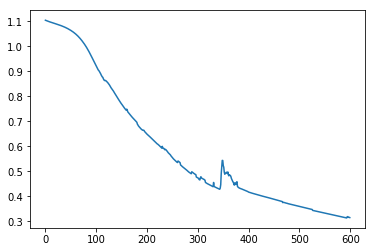

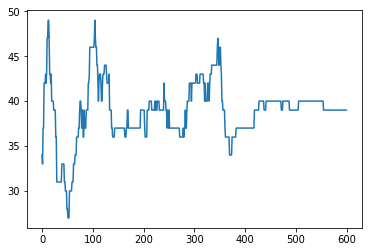

In [36]:
plt.plot(epoch_losses)
plt.show()
plt.plot(epoch_accuracies)

In [ ]:
s